In [5]:
# ============================================================================
# CELL 1: Import Libraries
# ============================================================================
"""
Heart Disease Prediction - Comprehensive Analysis
Date: 2026-01-04

This notebook performs end-to-end machine learning pipeline for predicting
heart disease based on medical indicators.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

import xgboost as xgb
import joblib

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.2


In [6]:
# ============================================================================
# CELL 2: Load Dataset
# ============================================================================
"""
Load the Heart Disease dataset
Dataset: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
"""

# Load from local file
df = pd.read_csv('data/heart_disease.csv')

print("✅ Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Display column names
print(f"\n📋 Original column names:")
print(df.columns.tolist())

✅ Dataset loaded successfully!

Dataset shape: (270, 14)
Number of samples: 270
Number of features: 14

📋 Original column names:
['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']


In [7]:
# ============================================================================
# CELL 3: Column Mapping and Renaming
# ============================================================================
"""
Map original column names to standard medical abbreviations
"""

# Define column mapping
column_mapping = {
    'Age': 'age',
    'Sex': 'sex',
    'Chest pain type': 'cp',
    'BP': 'trestbps',
    'Cholesterol': 'chol',
    'FBS over 120': 'fbs',
    'EKG results': 'restecg',
    'Max HR': 'thalach',
    'Exercise angina': 'exang',
    'ST depression': 'oldpeak',
    'Slope of ST': 'slope',
    'Number of vessels fluro': 'ca',
    'Thallium': 'thal',
    'Heart Disease': 'target'
}

print("=" * 80)
print("COLUMN MAPPING")
print("=" * 80)
print("\n📋 Mapping original names to standard abbreviations:")
for old_name, new_name in column_mapping.items():
    print(f"  {old_name:30s} → {new_name}")

# Rename columns
df = df.rename(columns=column_mapping)

print(f"\n✅ Columns renamed successfully!")
print(f"New column names: {df.columns.tolist()}")

COLUMN MAPPING

📋 Mapping original names to standard abbreviations:
  Age                            → age
  Sex                            → sex
  Chest pain type                → cp
  BP                             → trestbps
  Cholesterol                    → chol
  FBS over 120                   → fbs
  EKG results                    → restecg
  Max HR                         → thalach
  Exercise angina                → exang
  ST depression                  → oldpeak
  Slope of ST                    → slope
  Number of vessels fluro        → ca
  Thallium                       → thal
  Heart Disease                  → target

✅ Columns renamed successfully!
New column names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [8]:
# ============================================================================
# CELL 4: Target Variable Encoding
# ============================================================================
"""
Convert target variable from string to binary (0/1)
"""

print("=" * 80)
print("TARGET VARIABLE ENCODING")
print("=" * 80)

# Check target variable type and unique values
print(f"\n📊 Target variable dtype: {df['target'].dtype}")
print(f"Unique values in target: {df['target'].unique()}")
print(f"Value counts:\n{df['target'].value_counts()}")

# Encode target variable to binary
# Presence = 1 (Disease), Absence = 0 (No Disease)
if df['target'].dtype == 'object':
    label_encoder = LabelEncoder()
    df['target'] = label_encoder.fit_transform(df['target'])

    print(f"\n✅ Target variable encoded to binary:")
    print(f"  Classes: {label_encoder.classes_}")
    print(f"  Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

    # Save the encoder for later use
    target_classes = label_encoder.classes_
else:
    print("\n✅ Target variable is already numeric")
    target_classes = ['No Disease', 'Disease']

print(f"\nEncoded value counts:\n{df['target'].value_counts()}")

TARGET VARIABLE ENCODING

📊 Target variable dtype: object
Unique values in target: ['Presence' 'Absence']
Value counts:
target
Absence     150
Presence    120
Name: count, dtype: int64

✅ Target variable encoded to binary:
  Classes: ['Absence' 'Presence']
  Mapping: {'Absence': np.int64(0), 'Presence': np.int64(1)}

Encoded value counts:
target
0    150
1    120
Name: count, dtype: int64


In [9]:
# ============================================================================
# CELL 5: Initial Data Exploration
# ============================================================================
"""
Quick overview of the dataset structure
"""

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

# First rows
print("\n📊 First 5 rows:")
display(df.head())

print("\n📊 Last 5 rows:")
display(df.tail())

# Data types and non-null counts
print("\n📋 Dataset Info:")
df.info()

DATASET OVERVIEW

📊 First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0



📊 Last 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0
269,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   chol      270 non-null    int64  
 5   fbs       270 non-null    int64  
 6   restecg   270 non-null    int64  
 7   thalach   270 non-null    int64  
 8   exang     270 non-null    int64  
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    int64  
 11  ca        270 non-null    int64  
 12  thal      270 non-null    int64  
 13  target    270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB


In [11]:
# ============================================================================
# CELL 6: Feature Description
# ============================================================================
"""
Understanding each feature in the dataset
"""

feature_descriptions = {
    'age': 'Age in years',
    'sex': 'Sex (1 = male; 0 = female)',
    'cp': 'Chest pain type (0-3): 0=typical angina, 1=atypical angina, 2=non-anginal, 3=asymptomatic',
    'trestbps': 'Resting blood pressure (mm Hg on admission)',
    'chol': 'Serum cholesterol (mg/dl)',
    'fbs': 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
    'restecg': 'Resting electrocardiographic results (0-2)',
    'thalach': 'Maximum heart rate achieved',
    'exang': 'Exercise induced angina (1 = yes; 0 = no)',
    'oldpeak': 'ST depression induced by exercise relative to rest',
    'slope': 'Slope of peak exercise ST segment (0-2)',
    'ca': 'Number of major vessels colored by fluoroscopy (0-3)',
    'thal': 'Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)',
    'target': 'Heart disease diagnosis (1 = disease; 0 = no disease)'
}

print("=" * 80)
print("FEATURE DESCRIPTIONS")
print("=" * 80)
for feature, description in feature_descriptions.items():
    print(f"• {feature:12s}: {description}")

FEATURE DESCRIPTIONS
• age         : Age in years
• sex         : Sex (1 = male; 0 = female)
• cp          : Chest pain type (0-3): 0=typical angina, 1=atypical angina, 2=non-anginal, 3=asymptomatic
• trestbps    : Resting blood pressure (mm Hg on admission)
• chol        : Serum cholesterol (mg/dl)
• fbs         : Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
• restecg     : Resting electrocardiographic results (0-2)
• thalach     : Maximum heart rate achieved
• exang       : Exercise induced angina (1 = yes; 0 = no)
• oldpeak     : ST depression induced by exercise relative to rest
• slope       : Slope of peak exercise ST segment (0-2)
• ca          : Number of major vessels colored by fluoroscopy (0-3)
• thal        : Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)
• target      : Heart disease diagnosis (1 = disease; 0 = no disease)


In [12]:
# ============================================================================
# CELL 7: Statistical Summary
# ============================================================================
"""
Statistical summary of numerical features
"""

print("=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

# Descriptive statistics
print("\n📈 Numerical Features Statistics:")
display(df.describe().T)

print("\n📊 Categorical Features Value Counts:")
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().sort_index())

STATISTICAL SUMMARY

📈 Numerical Features Statistics:


,count,mean,std,min,25%,50%,75%,max
age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
cp,270.0,3.174074,0.950090,1.0,3.0,3.0,4.0,4.0
trestbps,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
chol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
fbs,270.0,0.148148,0.355906,0.0,0.0,0.0,0.0,1.0
restecg,270.0,1.022222,0.997891,0.0,0.0,2.0,2.0,2.0
thalach,270.0,149.677778,23.165717,71.0,133.0,153.5,166.0,202.0
exang,270.0,0.329630,0.470952,0.0,0.0,0.0,1.0,1.0
oldpeak,270.0,1.050000,1.145210,0.0,0.0,0.8,1.6,6.2



📊 Categorical Features Value Counts:

sex:
sex
0     87
1    183
Name: count, dtype: int64

cp:
cp
1     20
2     42
3     79
4    129
Name: count, dtype: int64

fbs:
fbs
0    230
1     40
Name: count, dtype: int64

restecg:
restecg
0    131
1      2
2    137
Name: count, dtype: int64

exang:
exang
0    181
1     89
Name: count, dtype: int64

slope:
slope
1    130
2    122
3     18
Name: count, dtype: int64

ca:
ca
0    160
1     58
2     33
3     19
Name: count, dtype: int64

thal:
thal
3    152
6     14
7    104
Name: count, dtype: int64

target:
target
0    150
1    120
Name: count, dtype: int64


In [13]:
# ============================================================================
# CELL 8: Missing Values Analysis
# ============================================================================
"""
Check for missing values and data quality issues
"""

print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

# Missing values count
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percent': missing_percent
})

print("\n🔍 Missing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("\n✅ No missing values found! Data quality is excellent.")
else:
    print(f"\n⚠️ Total missing values: {missing_df['Missing_Count'].sum()}")
    # Handle missing values if any
    df = df.dropna()
    print(f"✅ Missing values removed. New shape: {df.shape}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔍 Duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows. Consider removing them.")
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed. New shape: {df.shape}")

MISSING VALUES ANALYSIS

🔍 Missing Values Summary:
Empty DataFrame
Columns: [Missing_Count, Missing_Percent]
Index: []

✅ No missing values found! Data quality is excellent.

🔍 Duplicate rows: 0


TARGET VARIABLE ANALYSIS

🎯 Target Variable Distribution:
No Disease (0): 150 (55.56%)
Disease (1):    120 (44.44%)

Imbalance Ratio: 1.25
⚠️ Minor imbalance detected. Consider using stratified sampling.


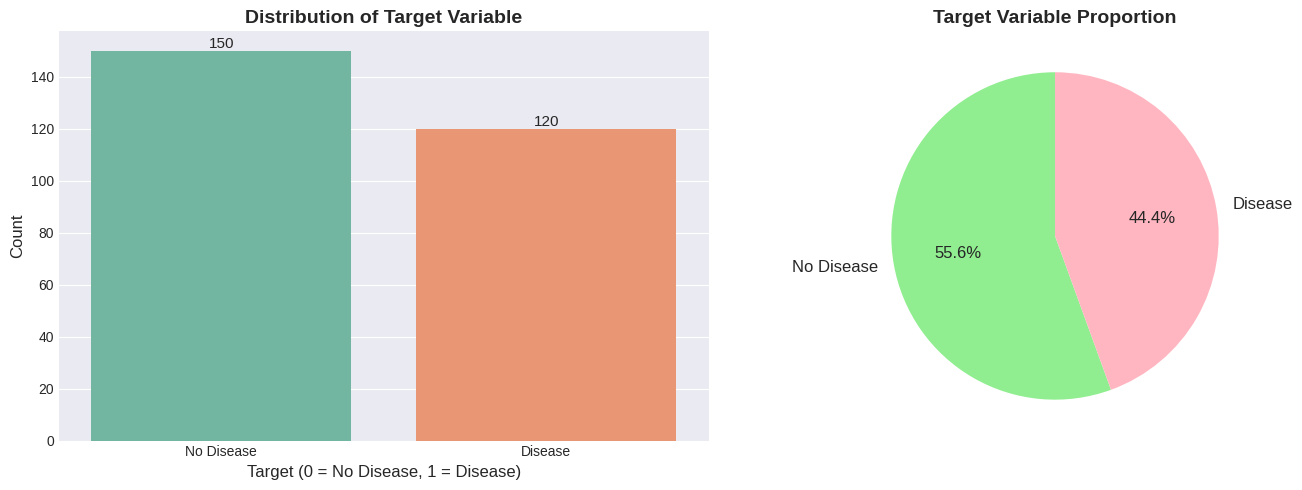

In [14]:
# ============================================================================
# CELL 9: Target Variable Analysis
# ============================================================================
"""
Analyze the distribution of the target variable (class balance)
"""

print("=" * 80)
print("TARGET VARIABLE ANALYSIS")
print("=" * 80)

# Class distribution
target_counts = df['target'].value_counts()
target_percent = (target_counts / len(df)) * 100

print("\n🎯 Target Variable Distribution:")
print(f"No Disease (0): {target_counts[0]} ({target_percent[0]:.2f}%)")
print(f"Disease (1):    {target_counts[1]} ({target_percent[1]:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

if abs(imbalance_ratio - 1) < 0.2:
    print("✅ Dataset is well-balanced!")
elif abs(imbalance_ratio - 1) < 0.5:
    print("⚠️ Minor imbalance detected. Consider using stratified sampling.")
else:
    print("⚠️ Significant imbalance! Consider using SMOTE or class weights.")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(x='target', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribution of Target Variable', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (0 = No Disease, 1 = Disease)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Disease', 'Disease'])

# Add counts on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=11)

# Pie chart
colors = ['#90EE90', '#FFB6C1']
axes[1].pie(target_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Target Variable Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

UNIVARIATE ANALYSIS - NUMERICAL FEATURES


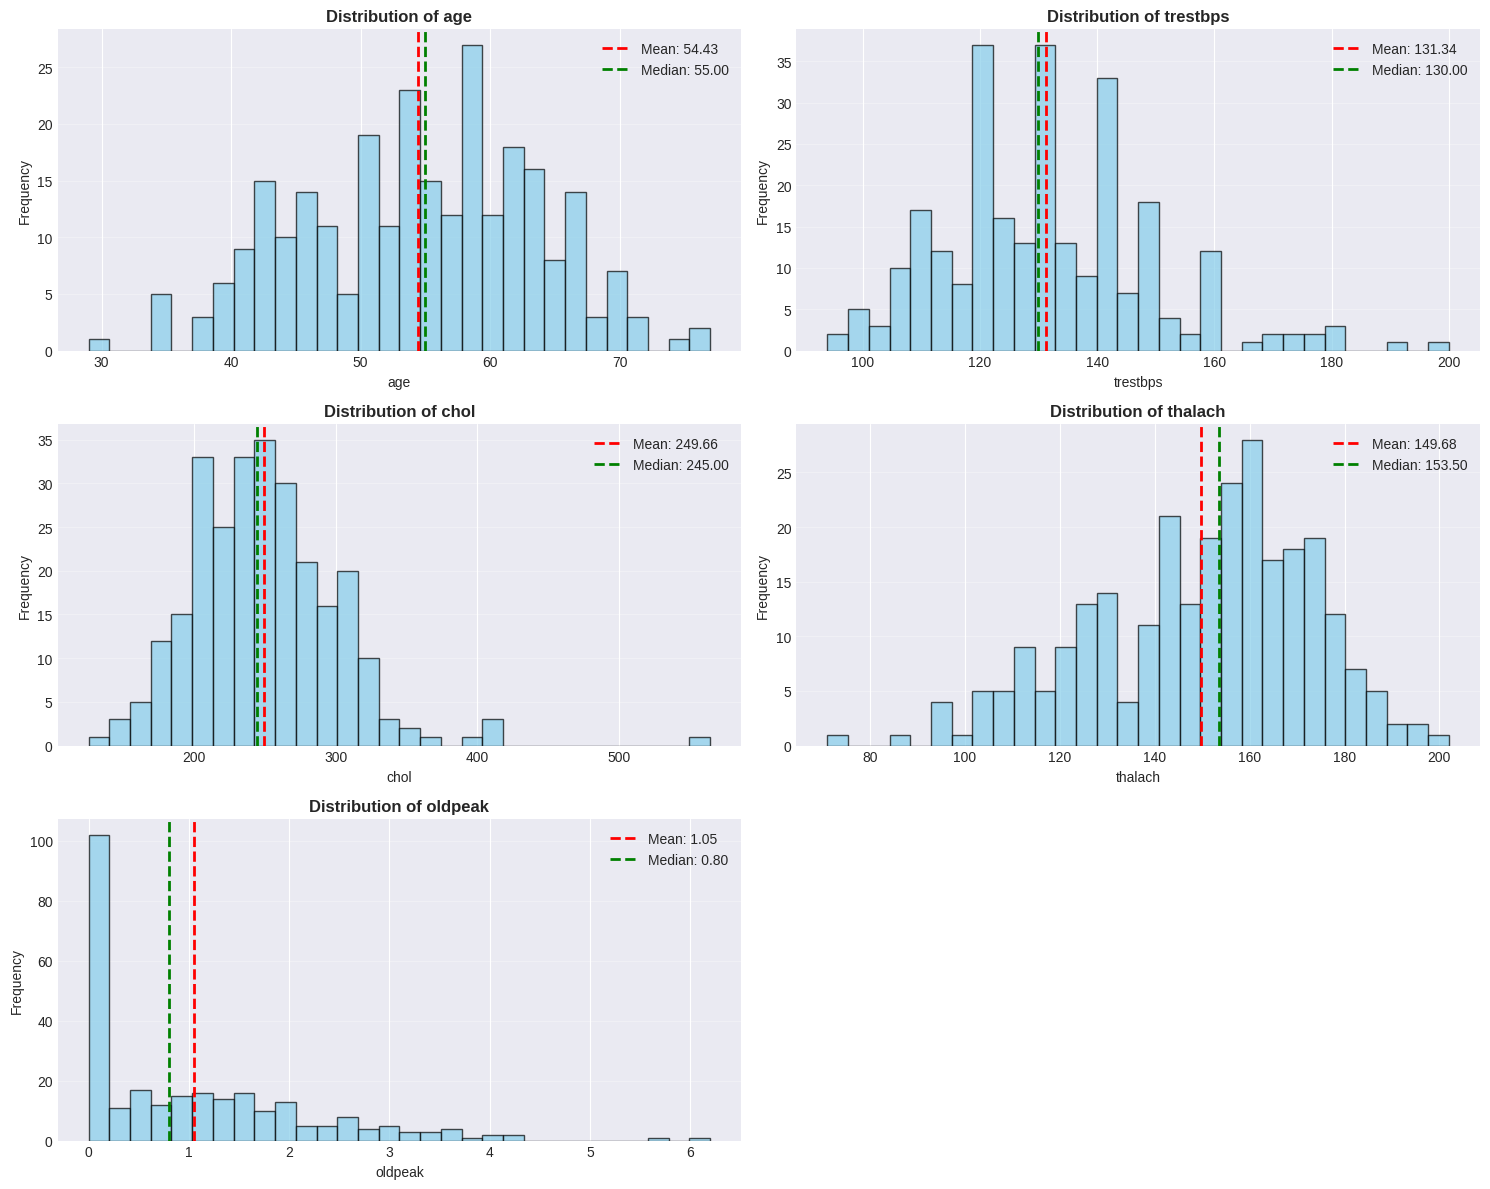

In [15]:
# ============================================================================
# CELL 10: Univariate Analysis - Numerical Features
# ============================================================================
"""
Distribution analysis of numerical features
"""

print("=" * 80)
print("UNIVARIATE ANALYSIS - NUMERICAL FEATURES")
print("=" * 80)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    # Histogram with KDE
    axes[idx].hist(df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].axvline(df[feature].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[feature].mean():.2f}')
    axes[idx].axvline(df[feature].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[feature].median():.2f}')
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Statistical tests for normality
print("\n📊 Skewness Analysis:")
for feature in numerical_features:
    skewness = df[feature].skew()
    print(f"{feature:12s}: {skewness:6.3f} ", end='')
    if abs(skewness) < 0.5:
        print("(Fairly Symmetric)")
    elif abs(skewness) < 1:
        print("(Moderately Skewed)")
    else:
        print("(Highly Skewed)")


📊 Skewness Analysis:
age         : -0.164 (Fairly Symmetric)
trestbps    :  0.723 (Moderately Skewed)
chol        :  1.184 (Highly Skewed)
thalach     : -0.528 (Moderately Skewed)
oldpeak     :  1.263 (Highly Skewed)


UNIVARIATE ANALYSIS - CATEGORICAL FEATURES


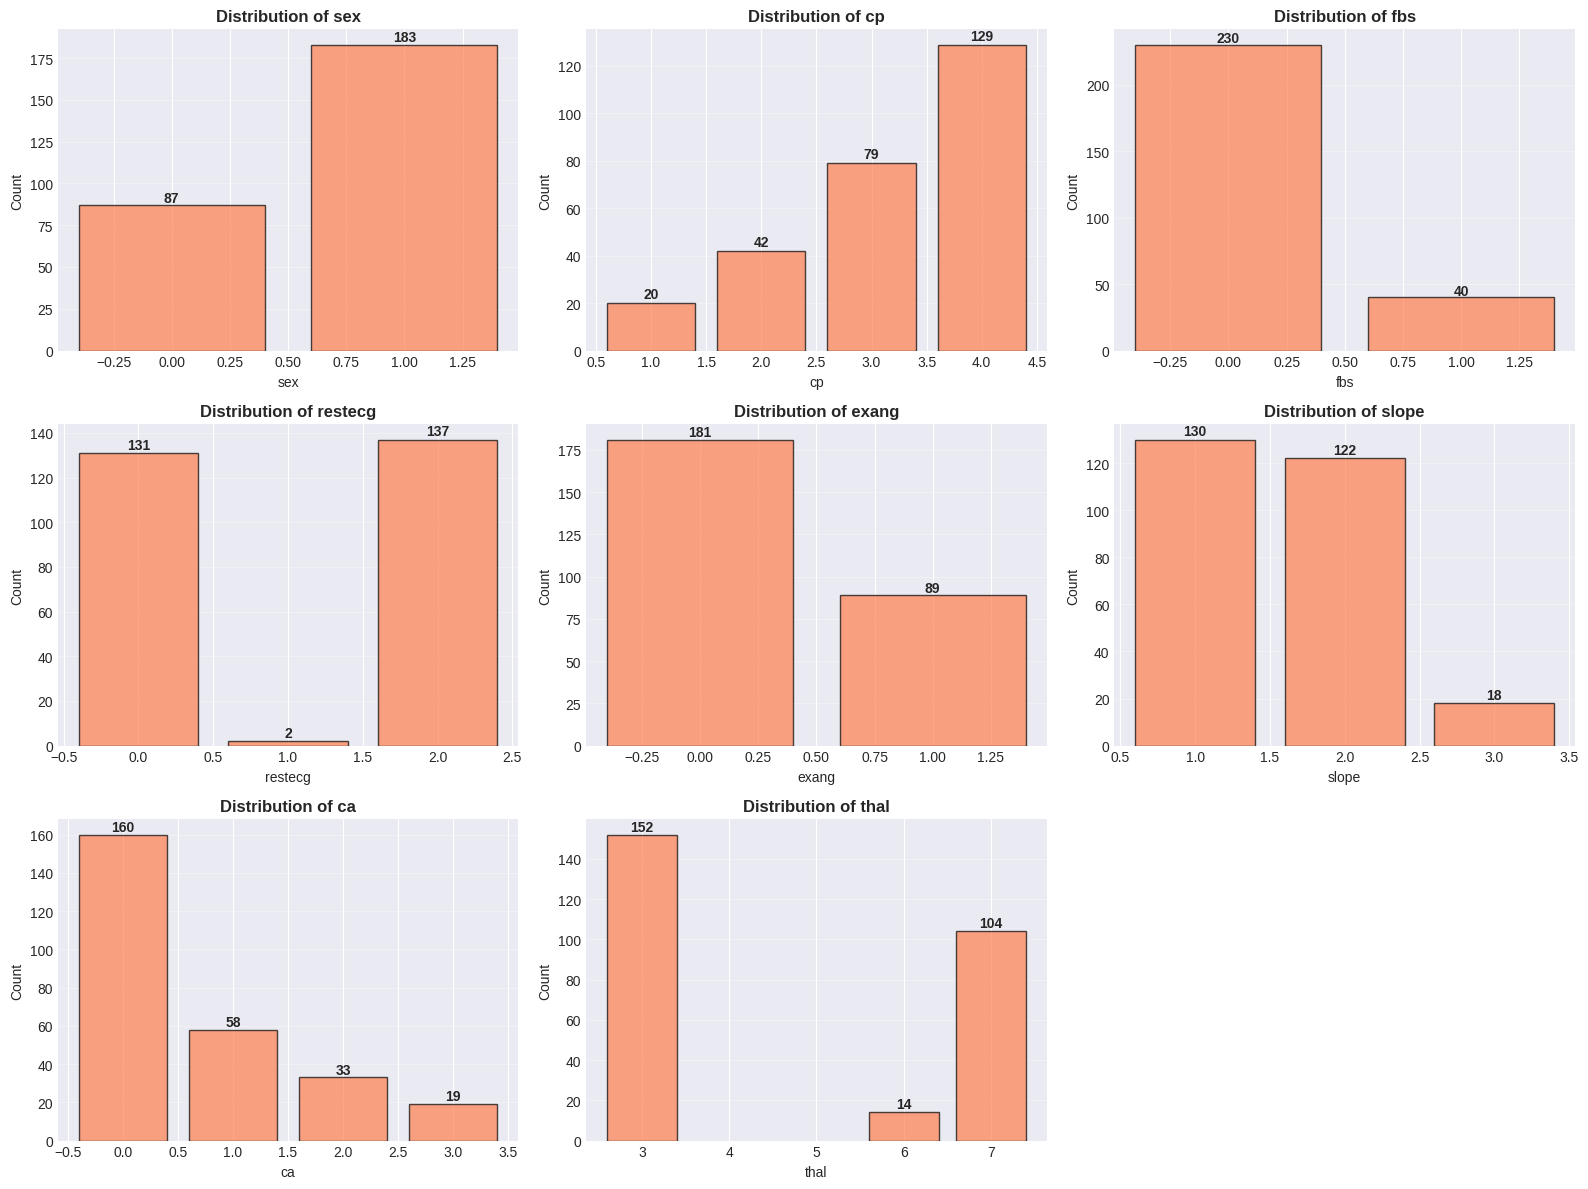

In [17]:
# ============================================================================
# CELL 11: Univariate Analysis - Categorical Features
# ============================================================================
"""
Distribution analysis of categorical features
"""

print("=" * 80)
print("UNIVARIATE ANALYSIS - CATEGORICAL FEATURES")
print("=" * 80)

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if feature in df.columns:
        value_counts = df[feature].value_counts().sort_index()
        axes[idx].bar(value_counts.index, value_counts.values, color='coral', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('Count', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(value_counts.values):
            axes[idx].text(value_counts.index[i], v + 2, str(v), ha='center', fontweight='bold')

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

BIVARIATE ANALYSIS - NUMERICAL FEATURES vs TARGET


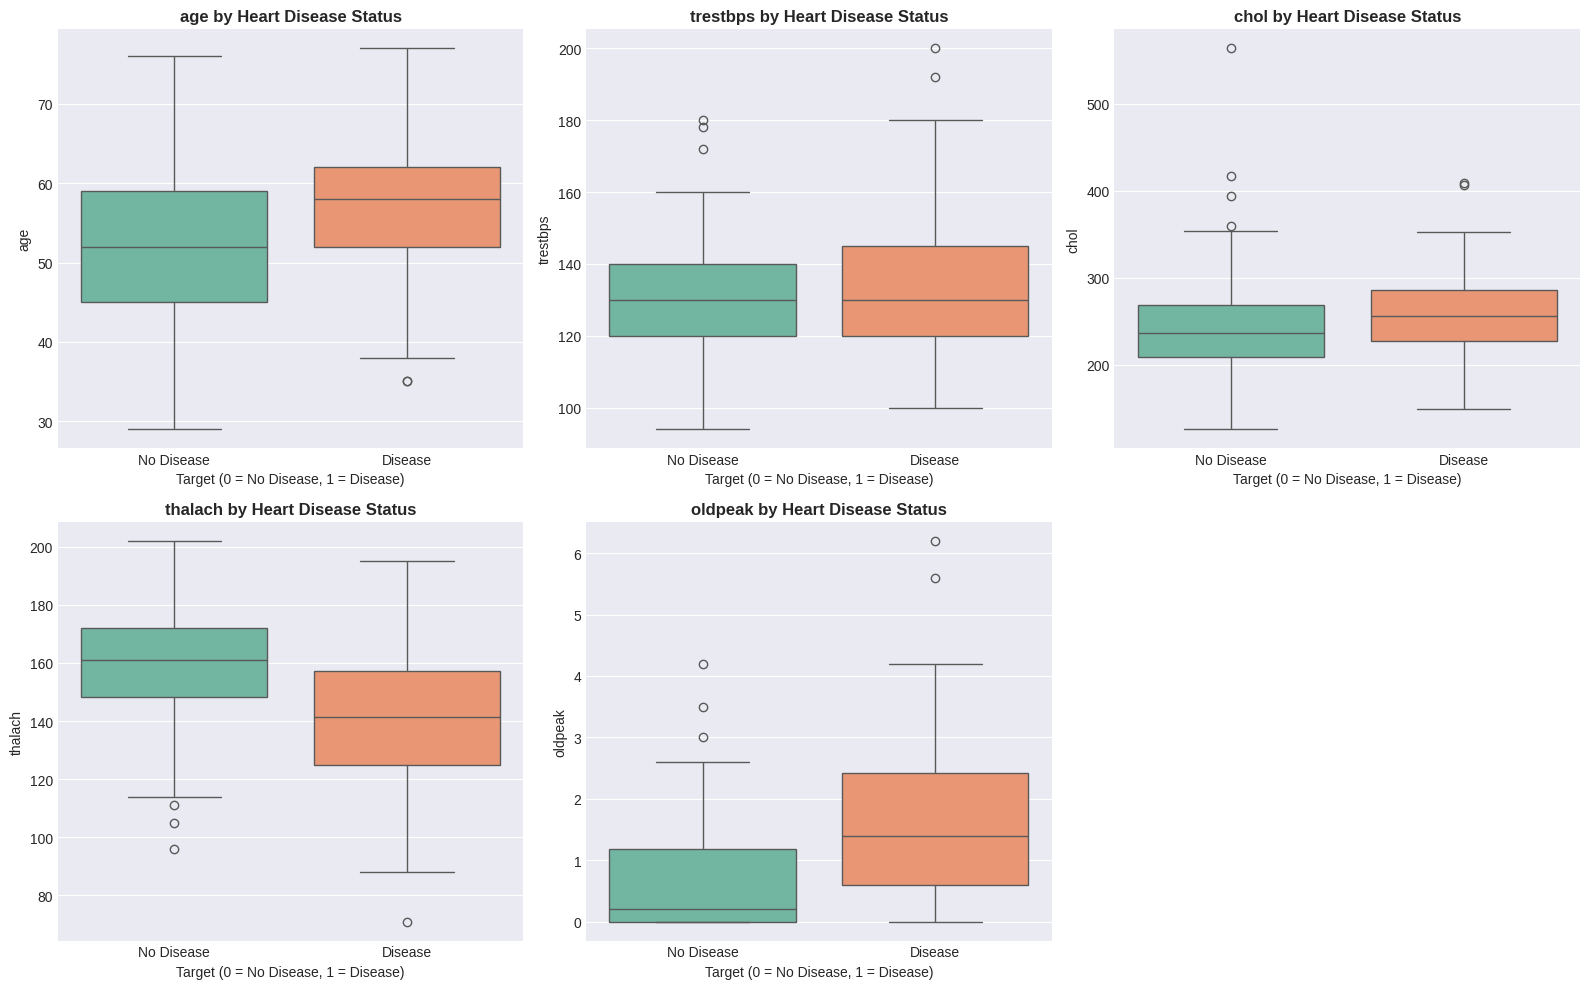

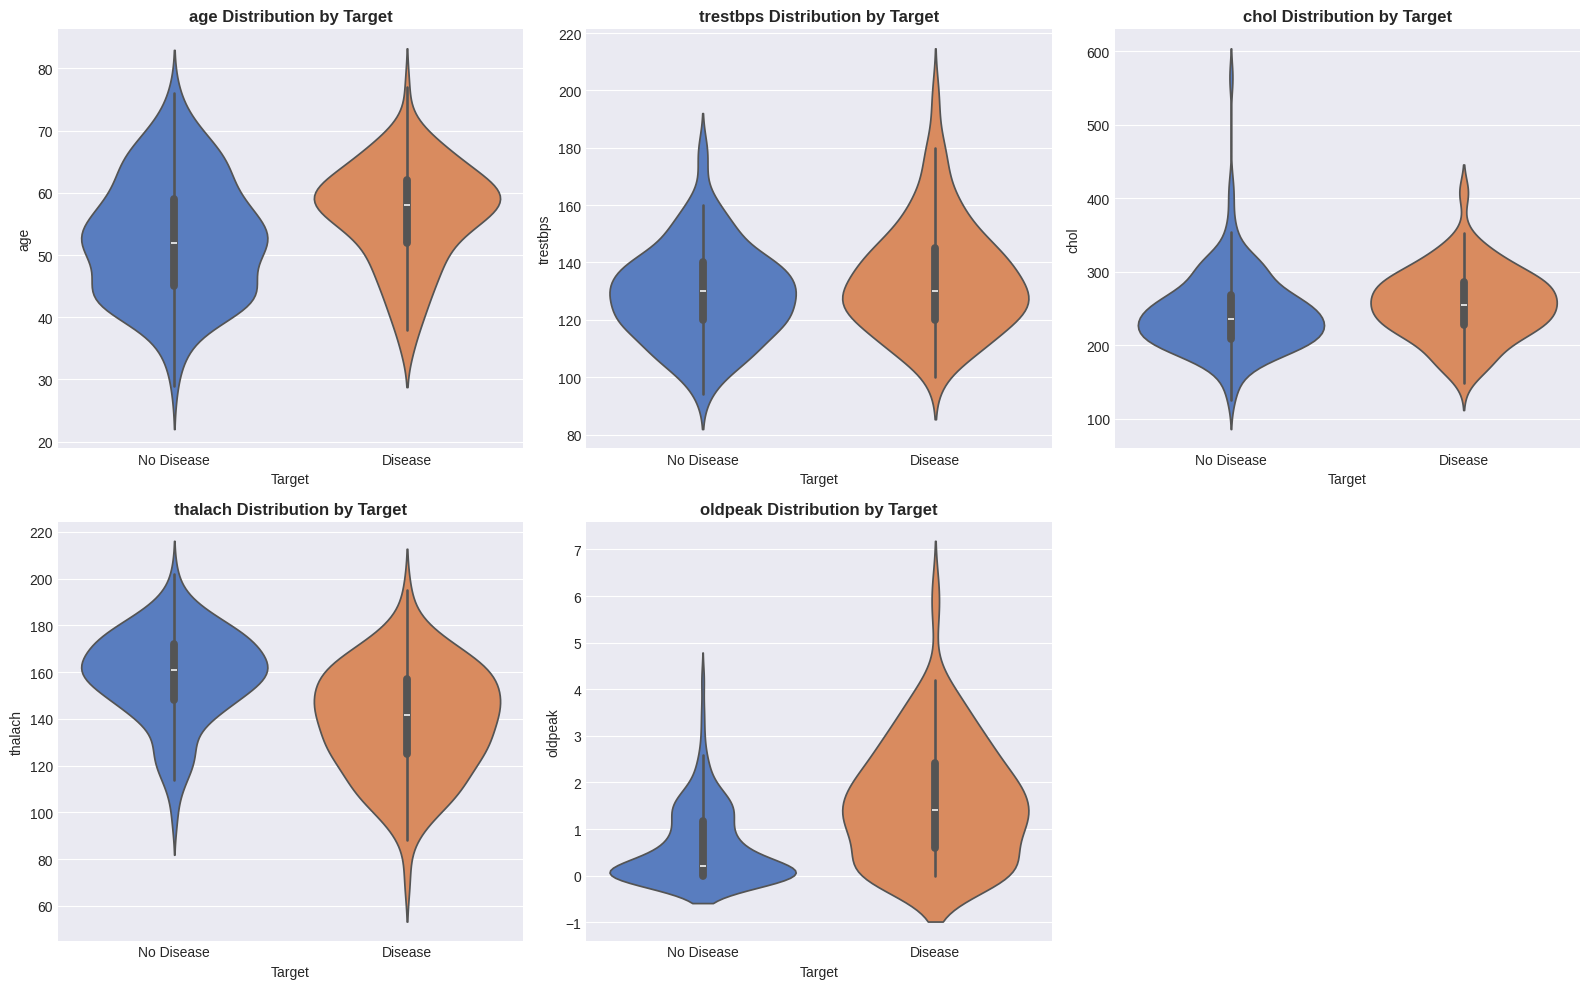


📊 Mean Values by Target:
          age  trestbps    chol  thalach  oldpeak
target                                           
0       52.71    128.87  244.21   158.33     0.62
1       56.59    134.44  256.47   138.86     1.58

📊 Median Values by Target:
         age  trestbps   chol  thalach  oldpeak
target                                         
0       52.0     130.0  236.0    161.0      0.2
1       58.0     130.0  255.5    141.5      1.4


In [18]:
# ============================================================================
# CELL 12: Bivariate Analysis - Numerical vs Target
# ============================================================================
"""
Analyze relationship between numerical features and target variable
"""

print("=" * 80)
print("BIVARIATE ANALYSIS - NUMERICAL FEATURES vs TARGET")
print("=" * 80)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Box plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.boxplot(x='target', y=feature, data=df, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{feature} by Heart Disease Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target (0 = No Disease, 1 = Disease)', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Violin plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.violinplot(x='target', y=feature, data=df, ax=axes[idx], palette='muted')
    axes[idx].set_title(f'{feature} Distribution by Target', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_xticklabels(['No Disease', 'Disease'])

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\n📊 Mean Values by Target:")
print(df.groupby('target')[numerical_features].mean().round(2))

print("\n📊 Median Values by Target:")
print(df.groupby('target')[numerical_features].median().round(2))

BIVARIATE ANALYSIS - CATEGORICAL FEATURES vs TARGET


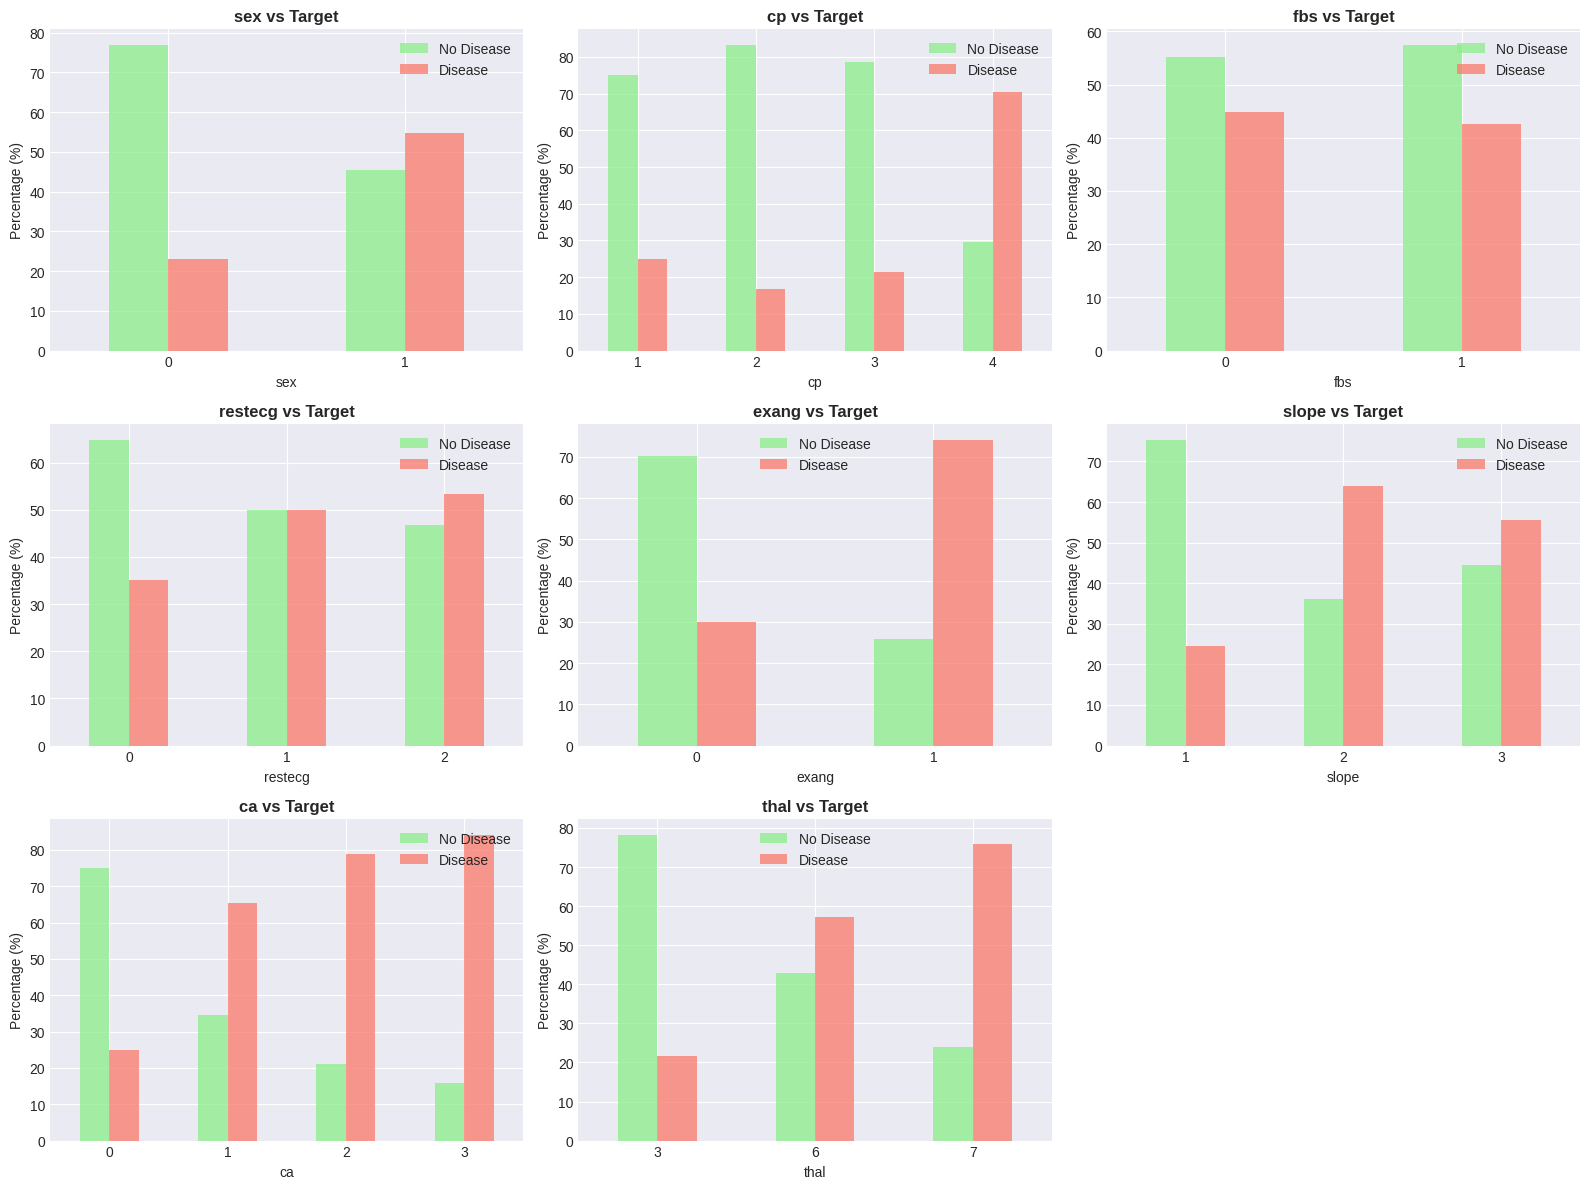


📊 Crosstab Analysis:

sex:
target    0    1  All
sex                  
0        67   20   87
1        83  100  183
All     150  120  270

cp:
target    0    1  All
cp                   
1        15    5   20
2        35    7   42
3        62   17   79
4        38   91  129
All     150  120  270

fbs:
target    0    1  All
fbs                  
0       127  103  230
1        23   17   40
All     150  120  270


In [19]:
# ============================================================================
# CELL 13: Bivariate Analysis - Categorical vs Target
# ============================================================================
"""
Analyze relationship between categorical features and target variable
"""

print("=" * 80)
print("BIVARIATE ANALYSIS - CATEGORICAL FEATURES vs TARGET")
print("=" * 80)

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if feature in df.columns:
        ct = pd.crosstab(df[feature], df['target'], normalize='index') * 100
        ct.plot(kind='bar', ax=axes[idx], color=['lightgreen', 'salmon'], alpha=0.8)
        axes[idx].set_title(f'{feature} vs Target', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('Percentage (%)', fontsize=10)
        axes[idx].legend(['No Disease', 'Disease'], loc='best')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Crosstab with counts
print("\n📊 Crosstab Analysis:")
for feature in categorical_features[:3]:  # Show first 3 to save space
    if feature in df.columns:
        print(f"\n{feature}:")
        print(pd.crosstab(df[feature], df['target'], margins=True))

CORRELATION ANALYSIS

📊 Correlation with Target:
target      1.000000
thal        0.525020
ca          0.455336
exang       0.419303
oldpeak     0.417967
cp          0.417436
slope       0.337616
sex         0.297721
age         0.212322
restecg     0.182091
trestbps    0.155383
chol        0.118021
fbs        -0.016319
thalach    -0.418514
Name: target, dtype: float64


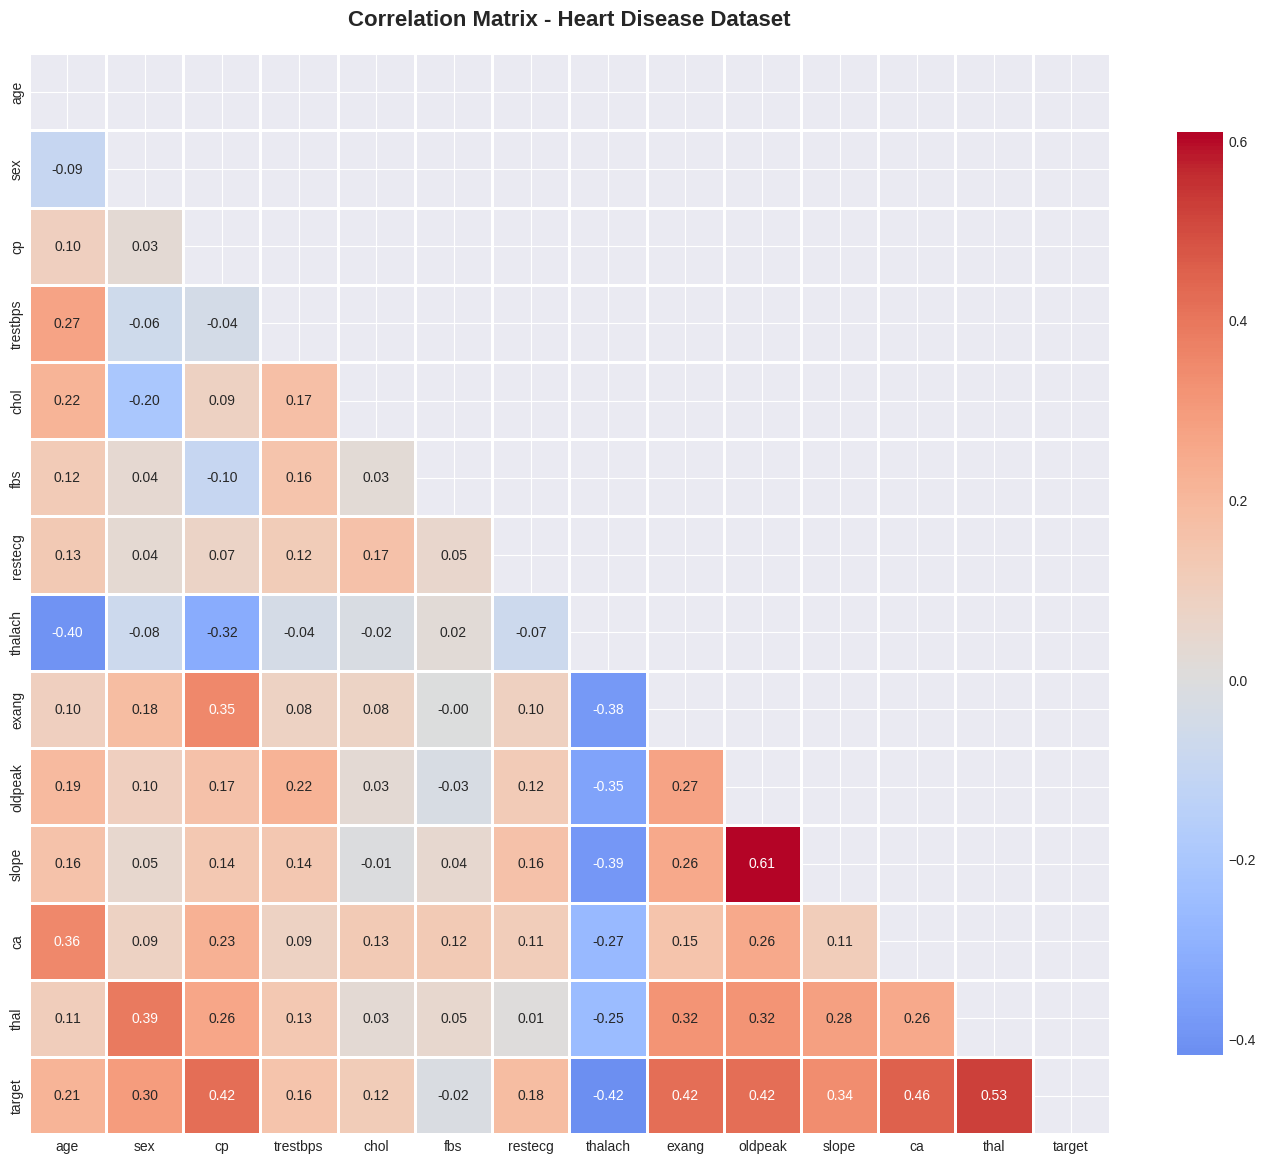


📊 Top Positive Correlations with Target:
thal        0.525020
ca          0.455336
exang       0.419303
oldpeak     0.417967
cp          0.417436
slope       0.337616
sex         0.297721
age         0.212322
restecg     0.182091
trestbps    0.155383
chol        0.118021
Name: target, dtype: float64

📊 Top Negative Correlations with Target:
thalach   -0.418514
Name: target, dtype: float64


In [20]:
# ============================================================================
# CELL 14: Correlation Analysis
# ============================================================================
"""
Analyze correlations between features
"""

print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Correlation matrix
correlation_matrix = df.corr()

print("\n📊 Correlation with Target:")
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print(target_corr)

# Heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Heart Disease Dataset', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top correlations with target
print("\n📊 Top Positive Correlations with Target:")
print(target_corr[target_corr > 0.1].drop('target'))

print("\n📊 Top Negative Correlations with Target:")
print(target_corr[target_corr < -0.1])

PAIRPLOT - KEY FEATURES
Creating pairplot for: age, trestbps, chol, thalach, oldpeak, target
This may take a moment...


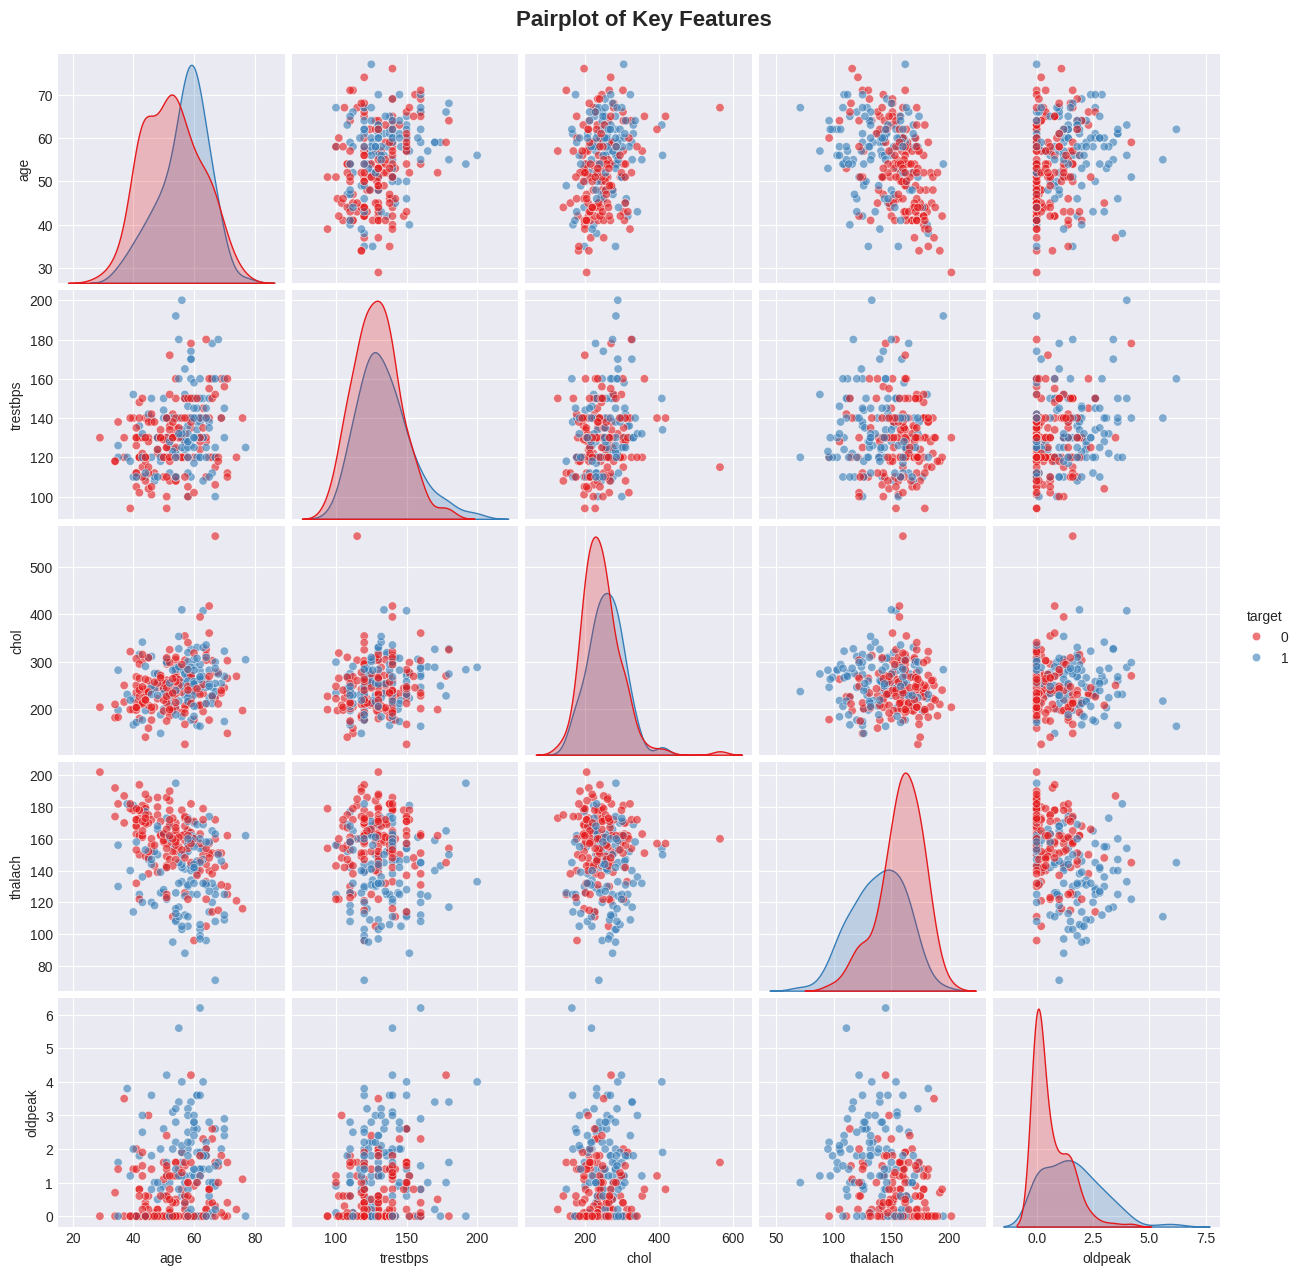

✅ Pairplot complete!


In [21]:
# ============================================================================
# CELL 15: Pairplot for Key Features
# ============================================================================
"""
Visualize relationships between key features
"""

print("=" * 80)
print("PAIRPLOT - KEY FEATURES")
print("=" * 80)

# Select key features based on correlation with target
key_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']

print(f"Creating pairplot for: {', '.join(key_features)}")
print("This may take a moment...")

pairplot = sns.pairplot(df[key_features], hue='target', palette='Set1',
                        diag_kind='kde', plot_kws={'alpha': 0.6},
                        height=2.5)
pairplot.fig.suptitle('Pairplot of Key Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()

print("✅ Pairplot complete!")

OUTLIER DETECTION

📊 Outlier Summary (IQR Method):
Feature      Outliers   Percentage   Lower Bound     Upper Bound    
----------------------------------------------------------------------
age          0          0.00        % 28.50           80.50          
trestbps     9          3.33        % 90.00           170.00         
chol         5          1.85        % 112.50          380.50         
thalach      1          0.37        % 83.50           215.50         
oldpeak      4          1.48        % -2.40           4.00           


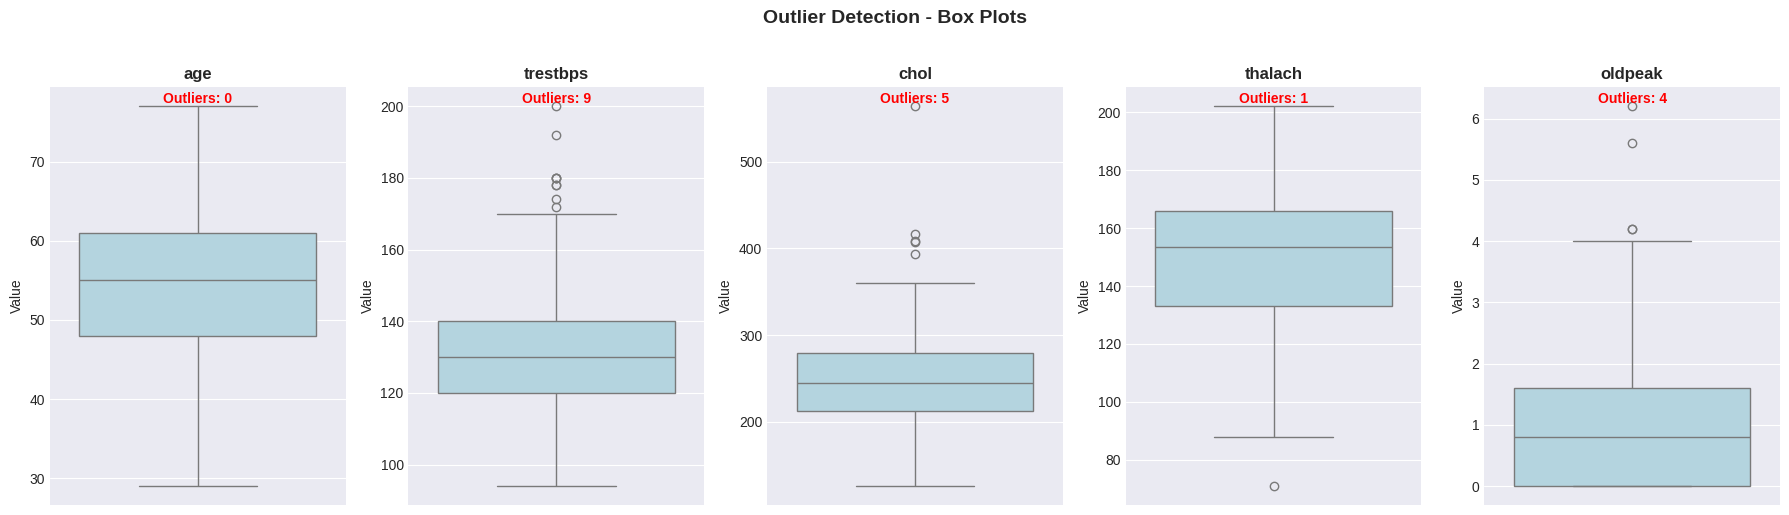


💡 Note: Outliers are not necessarily errors. In medical data, extreme values may be important!
We will keep outliers as they may represent critical cases.


In [22]:
# ============================================================================
# CELL 16: Outlier Detection
# ============================================================================
"""
Detect and visualize outliers using IQR method
"""

print("=" * 80)
print("OUTLIER DETECTION")
print("=" * 80)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("\n📊 Outlier Summary (IQR Method):")
print(f"{'Feature':<12} {'Outliers':<10} {'Percentage':<12} {'Lower Bound':<15} {'Upper Bound':<15}")
print("-" * 70)

outlier_summary = {}
for feature in numerical_features:
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100
    outlier_summary[feature] = outlier_count
    print(f"{feature:<12} {outlier_count:<10} {outlier_pct:<12.2f}% {lower:<15.2f} {upper:<15.2f}")

# Boxplot for outlier visualization
fig, axes = plt.subplots(1, len(numerical_features), figsize=(18, 5))

for idx, feature in enumerate(numerical_features):
    sns.boxplot(y=df[feature], ax=axes[idx], color='lightblue')
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value', fontsize=10)

    # Add count of outliers
    outlier_count = outlier_summary[feature]
    axes[idx].text(0, df[feature].max(), f'Outliers: {outlier_count}',
                   ha='center', va='bottom', fontweight='bold', color='red')

plt.suptitle('Outlier Detection - Box Plots', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Note: Outliers are not necessarily errors. In medical data, extreme values may be important!")
print("We will keep outliers as they may represent critical cases.")

In [23]:
# ============================================================================
# CELL 17: Data Preprocessing - Train/Test Split
# ============================================================================
"""
Split data into training and testing sets
"""

print("=" * 80)
print("DATA PREPROCESSING - TRAIN/TEST SPLIT")
print("=" * 80)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

print(f"\n📊 Original Dataset:")
print(f"Total samples: {len(df)}")
print(f"Features: {X.shape[1]}")
print(f"Target distribution:\n{y.value_counts()}")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n📊 After Split:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\n📊 Training Set Target Distribution:")
print(y_train.value_counts())
print(f"Class proportion: {y_train.value_counts(normalize=True).round(3).to_dict()}")

print(f"\n📊 Testing Set Target Distribution:")
print(y_test.value_counts())
print(f"Class proportion: {y_test.value_counts(normalize=True).round(3).to_dict()}")

print("\n✅ Stratified split ensures balanced class distribution in both sets!")

DATA PREPROCESSING - TRAIN/TEST SPLIT

📊 Original Dataset:
Total samples: 270
Features: 13
Target distribution:
target
0    150
1    120
Name: count, dtype: int64

📊 After Split:
Training set: 216 samples (80.0%)
Testing set:  54 samples (20.0%)

📊 Training Set Target Distribution:
target
0    120
1     96
Name: count, dtype: int64
Class proportion: {0: 0.556, 1: 0.444}

📊 Testing Set Target Distribution:
target
0    30
1    24
Name: count, dtype: int64
Class proportion: {0: 0.556, 1: 0.444}

✅ Stratified split ensures balanced class distribution in both sets!


FEATURE SCALING
✅ Features scaled using StandardScaler

📊 Scaling Statistics (from training data):
Feature      Original Mean   Original Std    Scaled Mean     Scaled Std     
---------------------------------------------------------------------------
age          54.36           9.27            -0.000000       1.002323       
sex          0.69            0.47            -0.000000       1.002323       
cp           3.10            0.98            0.000000        1.002323       
trestbps     131.07          17.40           -0.000000       1.002323       
chol         248.29          51.61           -0.000000       1.002323       
fbs          0.13            0.34            -0.000000       1.002323       
restecg      1.05            1.00            0.000000        1.002323       
thalach      150.56          22.33           0.000000        1.002323       
exang        0.32            0.47            0.000000        1.002323       
oldpeak      1.04            1.12            0.000000  

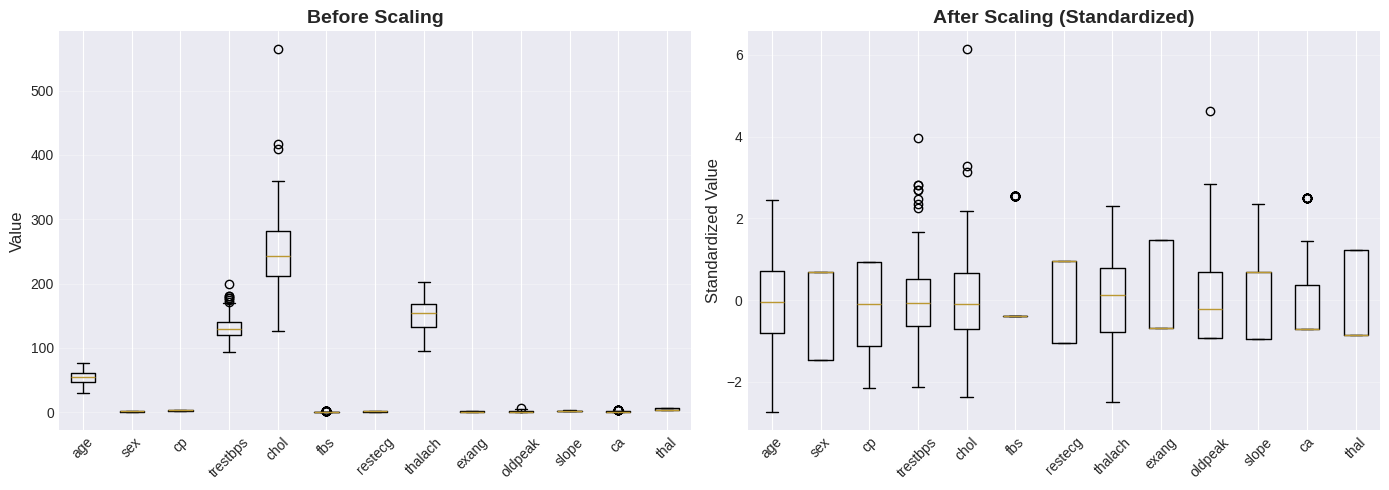

In [24]:
# ============================================================================
# CELL 18: Feature Scaling
# ============================================================================
"""
Standardize features using StandardScaler
"""

print("=" * 80)
print("FEATURE SCALING")
print("=" * 80)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("✅ Features scaled using StandardScaler")
print("\n📊 Scaling Statistics (from training data):")
print(f"{'Feature':<12} {'Original Mean':<15} {'Original Std':<15} {'Scaled Mean':<15} {'Scaled Std':<15}")
print("-" * 75)

for col in X.columns:
    orig_mean = X_train[col].mean()
    orig_std = X_train[col].std()
    scaled_mean = X_train_scaled[col].mean()
    scaled_std = X_train_scaled[col].std()
    print(f"{col:<12} {orig_mean:<15.2f} {orig_std:<15.2f} {scaled_mean:<15.6f} {scaled_std:<15.6f}")

# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].boxplot([X_train[col] for col in X.columns], labels=X.columns)
axes[0].set_title('Before Scaling', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# After scaling
axes[1].boxplot([X_train_scaled[col] for col in X.columns], labels=X.columns)
axes[1].set_title('After Scaling (Standardized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Standardized Value', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# ============================================================================
# CELL 19: Baseline Model - Dummy Classifier
# ============================================================================
"""
Establish baseline performance using a dummy classifier
"""

print("=" * 80)
print("BASELINE MODEL - DUMMY CLASSIFIER")
print("=" * 80)

from sklearn.dummy import DummyClassifier

# Most frequent strategy
dummy_most_frequent = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_most_frequent.fit(X_train_scaled, y_train)
dummy_pred_mf = dummy_most_frequent.predict(X_test_scaled)

# Stratified strategy
dummy_stratified = DummyClassifier(strategy='stratified', random_state=42)
dummy_stratified.fit(X_train_scaled, y_train)
dummy_pred_strat = dummy_stratified.predict(X_test_scaled)

print("\n📊 Baseline Performance:")
print(f"\nMost Frequent Strategy:")
print(f"  Accuracy: {accuracy_score(y_test, dummy_pred_mf):.4f}")

print(f"\nStratified Strategy:")
print(f"  Accuracy: {accuracy_score(y_test, dummy_pred_strat):.4f}")

baseline_accuracy = accuracy_score(y_test, dummy_pred_mf)
print(f"\n💡 Any model scoring below {baseline_accuracy:.4f} is worse than random guessing!")
print("✅ This is our minimum acceptable performance threshold.")

BASELINE MODEL - DUMMY CLASSIFIER

📊 Baseline Performance:

Most Frequent Strategy:
  Accuracy: 0.5556

Stratified Strategy:
  Accuracy: 0.5556

💡 Any model scoring below 0.5556 is worse than random guessing!
✅ This is our minimum acceptable performance threshold.


In [26]:
# ============================================================================
# CELL 20: Model Training - Multiple Algorithms
# ============================================================================
"""
Train multiple classification models and compare performance
"""

print("=" * 80)
print("MODEL TRAINING - MULTIPLE ALGORITHMS")
print("=" * 80)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Store results
results = {}

print("\n🚀 Training models...\n")

for name, model in models.items():
    print(f"Training {name}...", end=' ')

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    print(f"✅ Accuracy: {accuracy:.4f}")

print("\n✅ All models trained successfully!")

MODEL TRAINING - MULTIPLE ALGORITHMS

🚀 Training models...

Training Logistic Regression... ✅ Accuracy: 0.8519
Training Decision Tree... ✅ Accuracy: 0.7963
Training Random Forest... ✅ Accuracy: 0.8148
Training Gradient Boosting... ✅ Accuracy: 0.8148
Training XGBoost... ✅ Accuracy: 0.8148
Training SVM... ✅ Accuracy: 0.8148
Training K-Nearest Neighbors... ✅ Accuracy: 0.7963
Training Naive Bayes... ✅ Accuracy: 0.8519

✅ All models trained successfully!


MODEL COMPARISON - PERFORMANCE METRICS

📊 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.851852,0.785714,0.916667,0.846154,0.898611
7,Naive Bayes,0.851852,0.807692,0.875000,0.840000,0.893056
3,Gradient Boosting,0.814815,0.750000,0.875000,0.807692,0.886111
2,Random Forest,0.814815,0.769231,0.833333,0.800000,0.865972
5,SVM,0.814815,0.769231,0.833333,0.800000,0.886111
4,XGBoost,0.814815,0.769231,0.833333,0.800000,0.865278
1,Decision Tree,0.796296,0.740741,0.833333,0.784314,0.800000
6,K-Nearest Neighbors,0.796296,0.724138,0.875000,0.792453,0.875000


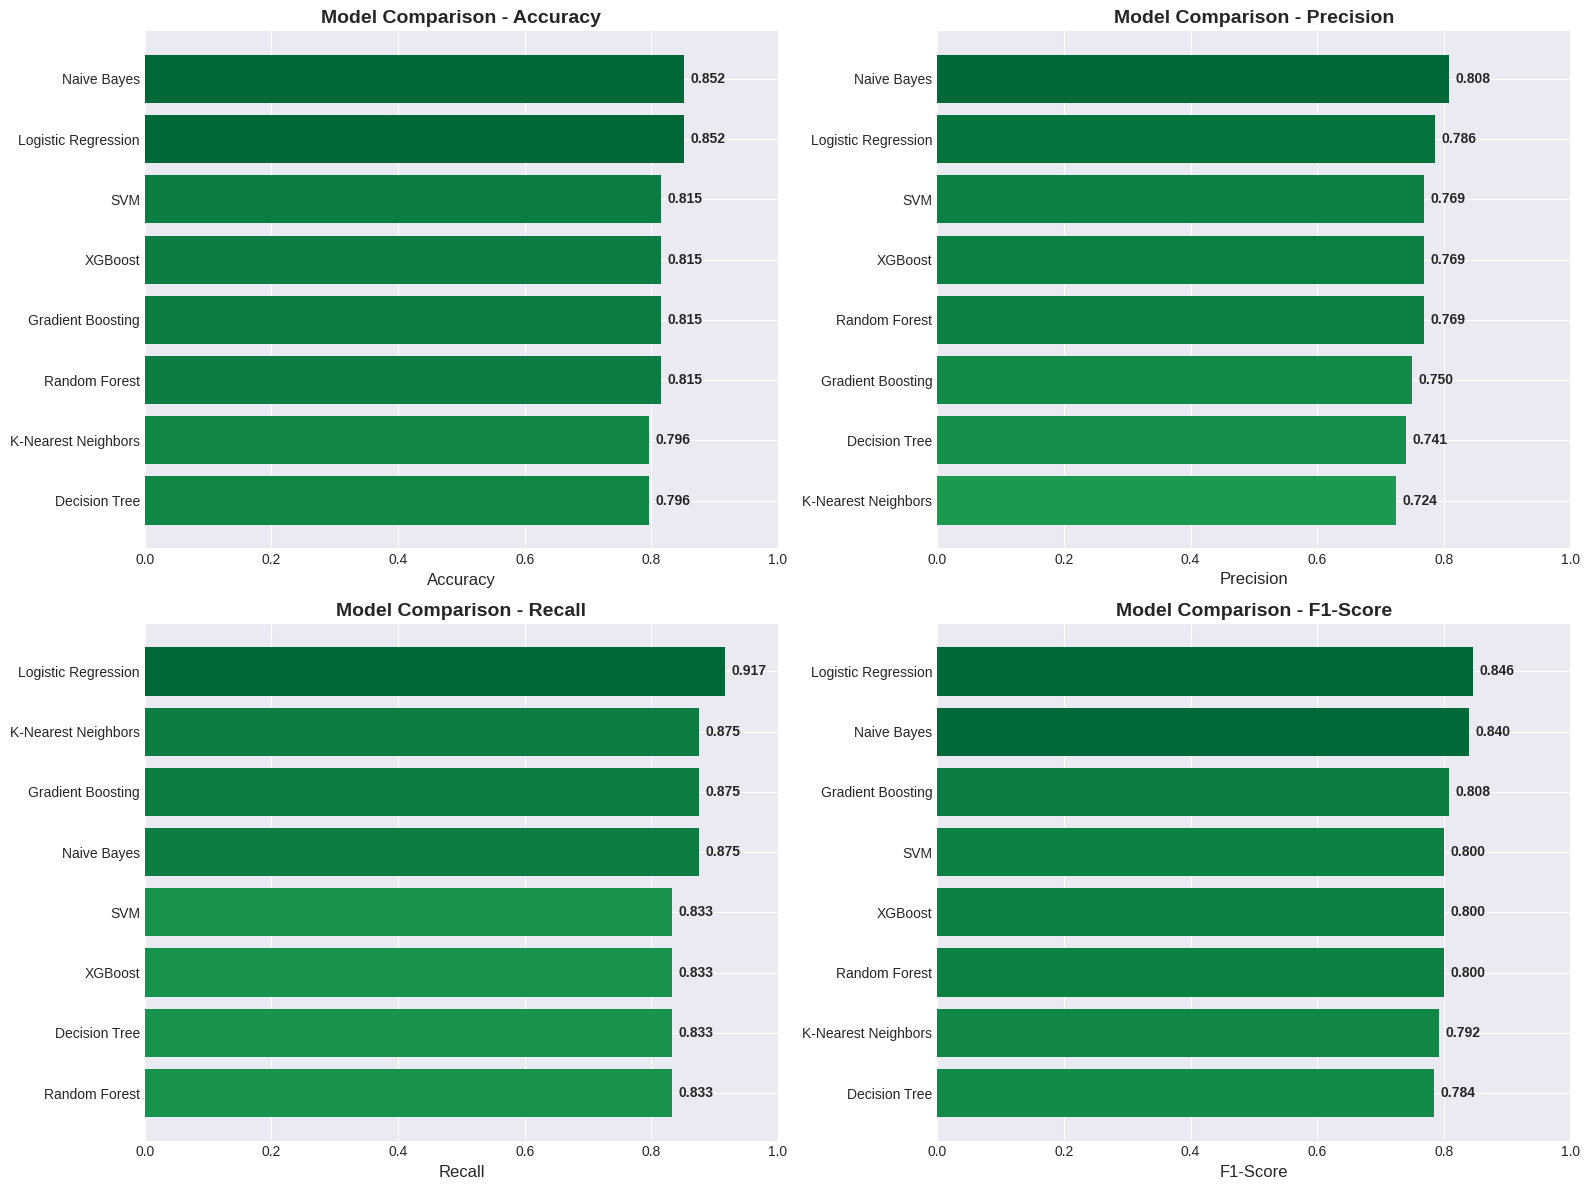


🏆 BEST MODEL: Logistic Regression
   Accuracy: 0.8519
   Improvement over baseline: 0.2963 (53.3%)


In [27]:
# ============================================================================
# CELL 21: Model Comparison - Performance Metrics
# ============================================================================
"""
Compare performance of all trained models
"""

print("=" * 80)
print("MODEL COMPARISON - PERFORMANCE METRICS")
print("=" * 80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("\n📊 Model Performance Comparison:")
display(comparison_df.style.background_gradient(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'], cmap='RdYlGn'))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    data = comparison_df.sort_values(metric, ascending=True)
    colors = plt.cm.RdYlGn(data[metric] / data[metric].max())

    ax.barh(data['Model'], data[metric], color=colors)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'Model Comparison - {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1])

    # Add value labels
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Improvement over baseline: {(best_accuracy - baseline_accuracy):.4f} ({(best_accuracy - baseline_accuracy)/baseline_accuracy*100:.1f}%)")

CROSS-VALIDATION ANALYSIS

🔄 Performing 5-Fold Cross-Validation...

Evaluating Logistic Regression... ✅ Mean CV Score: 0.8192 (±0.0618)
Evaluating Decision Tree... ✅ Mean CV Score: 0.7080 (±0.0492)
Evaluating Random Forest... ✅ Mean CV Score: 0.8146 (±0.0646)
Evaluating Gradient Boosting... ✅ Mean CV Score: 0.7870 (±0.0311)
Evaluating XGBoost... ✅ Mean CV Score: 0.7822 (±0.0940)
Evaluating SVM... ✅ Mean CV Score: 0.8331 (±0.0379)
Evaluating K-Nearest Neighbors... ✅ Mean CV Score: 0.8196 (±0.0262)
Evaluating Naive Bayes... ✅ Mean CV Score: 0.8471 (±0.0408)

📊 Cross-Validation Results:


,Model,CV Mean,CV Std,Test Accuracy
7,Naive Bayes,0.847146,0.040785,0.851852
5,SVM,0.833087,0.037944,0.814815
6,K-Nearest Neighbors,0.819556,0.026193,0.796296
0,Logistic Regression,0.819239,0.061797,0.851852
2,Random Forest,0.814588,0.064583,0.814815
3,Gradient Boosting,0.786998,0.031054,0.814815
4,XGBoost,0.782241,0.094027,0.814815
1,Decision Tree,0.708034,0.049249,0.796296


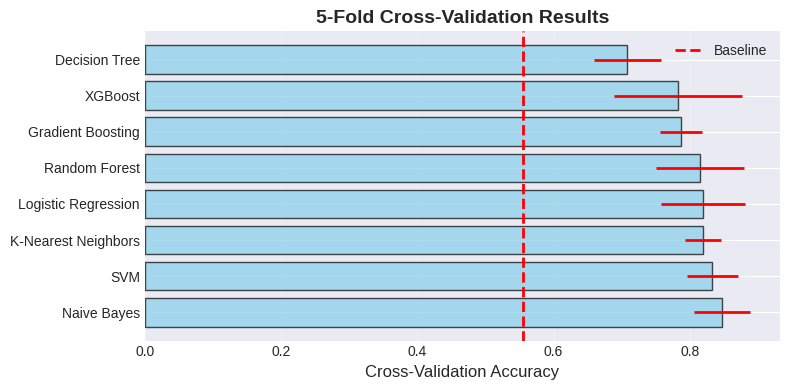


⚠️ Overfitting Check (CV Score vs Test Score):
Logistic Regression      : CV=0.8192, Test=0.8519, Diff=-0.0326 ✅ Good generalization
Decision Tree            : CV=0.7080, Test=0.7963, Diff=-0.0883 ⚠️ Potential overfitting/underfitting
Random Forest            : CV=0.8146, Test=0.8148, Diff=-0.0002 ✅ Good generalization
Gradient Boosting        : CV=0.7870, Test=0.8148, Diff=-0.0278 ✅ Good generalization
XGBoost                  : CV=0.7822, Test=0.8148, Diff=-0.0326 ✅ Good generalization
SVM                      : CV=0.8331, Test=0.8148, Diff=+0.0183 ✅ Good generalization
K-Nearest Neighbors      : CV=0.8196, Test=0.7963, Diff=+0.0233 ✅ Good generalization
Naive Bayes              : CV=0.8471, Test=0.8519, Diff=-0.0047 ✅ Good generalization


In [30]:
# ============================================================================
# CELL 22: Cross-Validation Analysis
# ============================================================================
"""
Perform k-fold cross-validation to assess model stability
"""

print("=" * 80)
print("CROSS-VALIDATION ANALYSIS")
print("=" * 80)

cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"\n🔄 Performing {cv_folds}-Fold Cross-Validation...\n")

cv_results = {}

for name, model in models.items():
    print(f"Evaluating {name}...", end=' ')

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

    cv_results[name] = {
        'scores': cv_scores,
        'mean': cv_scores.mean(),
        'std': cv_scores.std()
    }

    print(f"✅ Mean CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Create CV comparison DataFrame
cv_comparison_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV Mean': [cv_results[m]['mean'] for m in cv_results.keys()],
    'CV Std': [cv_results[m]['std'] for m in cv_results.keys()],
    'Test Accuracy': [results[m]['accuracy'] for m in cv_results.keys()]
}).sort_values('CV Mean', ascending=False)

print("\n📊 Cross-Validation Results:")
display(cv_comparison_df)

# Visualize CV results
plt.figure(figsize=(8, 4))

models_sorted = cv_comparison_df['Model'].values
cv_means = cv_comparison_df['CV Mean'].values
cv_stds = cv_comparison_df['CV Std'].values

y_pos = np.arange(len(models_sorted))

plt.barh(y_pos, cv_means, xerr=cv_stds, alpha=0.7, color='skyblue',
         edgecolor='black', error_kw={'elinewidth': 2, 'ecolor': 'red'})
plt.yticks(y_pos, models_sorted)
plt.xlabel('Cross-Validation Accuracy', fontsize=12)
plt.title(f'{cv_folds}-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
plt.axvline(x=baseline_accuracy, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
print("\n⚠️ Overfitting Check (CV Score vs Test Score):")
for name in cv_results.keys():
    cv_score = cv_results[name]['mean']
    test_score = results[name]['accuracy']
    diff = cv_score - test_score

    print(f"{name:25s}: CV={cv_score:.4f}, Test={test_score:.4f}, Diff={diff:+.4f}", end='')

    if abs(diff) > 0.05:
        print(" ⚠️ Potential overfitting/underfitting")
    else:
        print(" ✅ Good generalization")

ROC CURVES ANALYSIS


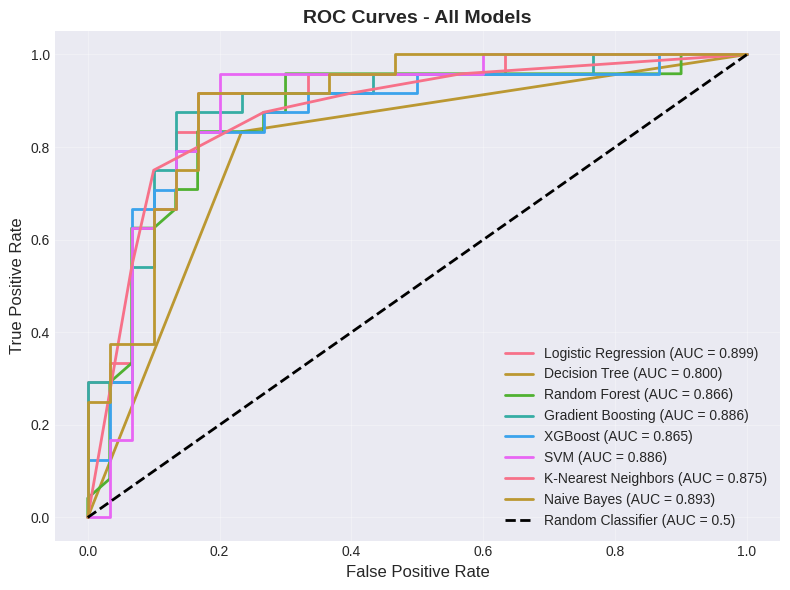


🏆 Best Model by ROC-AUC: Logistic Regression (AUC = 0.8986)


In [32]:
# ============================================================================
# CELL 24: ROC Curves
# ============================================================================
"""
Plot ROC curves for models with probability predictions
"""

print("=" * 80)
print("ROC CURVES ANALYSIS")
print("=" * 80)

plt.figure(figsize=(8, 6))

# Plot ROC curve for each model
for name, result in results.items():
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc = result['roc_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find best model by ROC-AUC
roc_auc_scores = {name: result['roc_auc'] for name, result in results.items() if not np.isnan(result['roc_auc'])}
best_roc_model = max(roc_auc_scores, key=roc_auc_scores.get)

print(f"\n🏆 Best Model by ROC-AUC: {best_roc_model} (AUC = {roc_auc_scores[best_roc_model]:.4f})")

FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST

📊 Feature Importance (Random Forest):


,Feature,Importance
2,cp,0.129436
7,thalach,0.118366
9,oldpeak,0.109802
11,ca,0.108405
12,thal,0.100866
4,chol,0.094452
0,age,0.083341
3,trestbps,0.071727
10,slope,0.062165
8,exang,0.050438


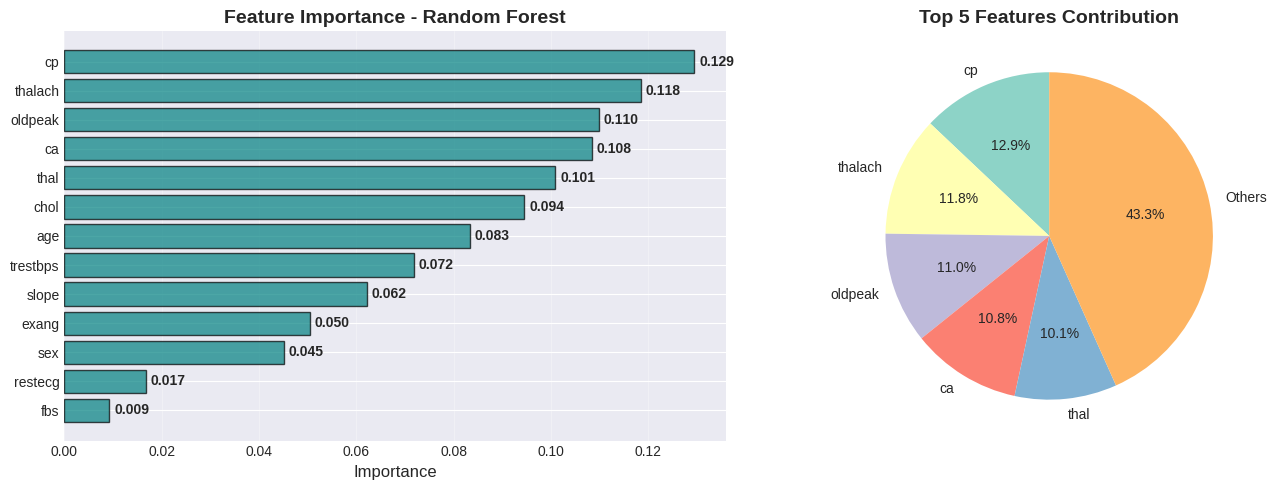


💡 Top 3 Most Important Features:
  1. cp: 0.1294
  2. thalach: 0.1184
  3. oldpeak: 0.1098


In [35]:
# ============================================================================
# CELL 25: Feature Importance - Random Forest
# ============================================================================
"""
Analyze feature importance from Random Forest model
"""

print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST")
print("=" * 80)

# Get Random Forest model
rf_model = results['Random Forest']['model']

# Extract feature importances
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance (Random Forest):")
display(feature_importance_rf)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'],
            color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add percentage labels
for i, v in enumerate(feature_importance_rf['Importance']):
    axes[0].text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')

# Pie chart for top features
top_n = 5
top_features = feature_importance_rf.head(top_n)
other_importance = feature_importance_rf.iloc[top_n:]['Importance'].sum()

pie_data = list(top_features['Importance']) + [other_importance]
pie_labels = list(top_features['Feature']) + ['Others']

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90,
           colors=sns.color_palette('Set3', len(pie_labels)))
axes[1].set_title(f'Top {top_n} Features Contribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Top 3 Most Important Features:")
for i, row in enumerate(feature_importance_rf.head(3).iterrows(), 1):
    idx, data = row
    print(f"  {i}. {data['Feature']}: {data['Importance']:.4f}")

In [36]:
# ============================================================================
# CELL 26: Hyperparameter Tuning - Random Forest
# ============================================================================
"""
Optimize Random Forest hyperparameters using GridSearchCV
"""

print("=" * 80)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("=" * 80)

# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print(f"\n🔍 Parameter Grid:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_rf.values()])
print(f"\nTotal combinations to test: {total_combinations}")

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\n🚀 Starting Grid Search for Random Forest... (this may take several minutes)")

# Fit grid search
grid_search_rf.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Complete!")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best Cross-Validation Score: {grid_search_rf.best_score_:.4f}")

# Test on test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_scaled)
y_pred_proba_best_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_roc_auc = roc_auc_score(y_test, y_pred_proba_best_rf)

print(f"📊 Test Set Accuracy: {best_rf_accuracy:.4f}")
print(f"📊 Test Set ROC-AUC: {best_rf_roc_auc:.4f}")
print(f"📊 Improvement over default RF: {best_rf_accuracy - results['Random Forest']['accuracy']:.4f}")

# Visualize grid search results (top 10 combinations)
cv_results_df = pd.DataFrame(grid_search_rf.cv_results_)
top_results = cv_results_df.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]

print("\n📊 Top 10 Parameter Combinations:")
display(top_results)

HYPERPARAMETER TUNING - RANDOM FOREST

🔍 Parameter Grid:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']

Total combinations to test: 216

🚀 Starting Grid Search for Random Forest... (this may take several minutes)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Grid Search Complete!

🏆 Best Parameters:
  max_depth: 5
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

📊 Best Cross-Validation Score: 0.8471
📊 Test Set Accuracy: 0.8333
📊 Test Set ROC-AUC: 0.8958
📊 Improvement over default RF: 0.0185

📊 Top 10 Parameter Combinations:


,params,mean_test_score,std_test_score,rank_test_score
2,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.847146,0.045783,1
29,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.847146,0.045783,1
17,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.833404,0.053575,3
44,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.833404,0.053575,3
10,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.833298,0.045195,5
14,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.833298,0.034311,5
24,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.833298,0.047528,5
37,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.833298,0.045195,5
41,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.833298,0.034311,5
51,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.833298,0.047528,5


HYPERPARAMETER TUNING - XGBOOST

🔍 Parameter Grid:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7]
  learning_rate: [0.01, 0.05, 0.1]
  subsample: [0.7, 0.8, 1.0]
  colsample_bytree: [0.7, 0.8, 1.0]

Total combinations to test: 243

🚀 Starting Grid Search for XGBoost... (this may take several minutes)
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

✅ Grid Search Complete!

🏆 Best Parameters:
  colsample_bytree: 1.0
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 100
  subsample: 0.7

📊 Best Cross-Validation Score: 0.8334
📊 Test Set Accuracy: 0.7963
📊 Test Set ROC-AUC: 0.8889
📊 Improvement over default XGBoost: -0.0185

📊 Top 10 Parameter Combinations:


,params,mean_test_score,std_test_score,rank_test_score
219,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.833404,0.064562,1
66,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.828858,0.066252,2
76,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.828858,0.076835,2
151,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.828858,0.076835,2
237,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.828858,0.066252,2
150,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.824419,0.077516,6
67,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.824313,0.077933,7
70,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.824313,0.077933,7
78,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.824313,0.075106,7
79,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.824313,0.077933,7



📊 Comparison: Default vs Tuned Models


,Model,Test Accuracy,ROC-AUC
0,RF (Default),0.814815,0.865972
1,RF (Tuned),0.833333,0.895833
2,XGBoost (Default),0.814815,0.865278
3,XGBoost (Tuned),0.796296,0.888889


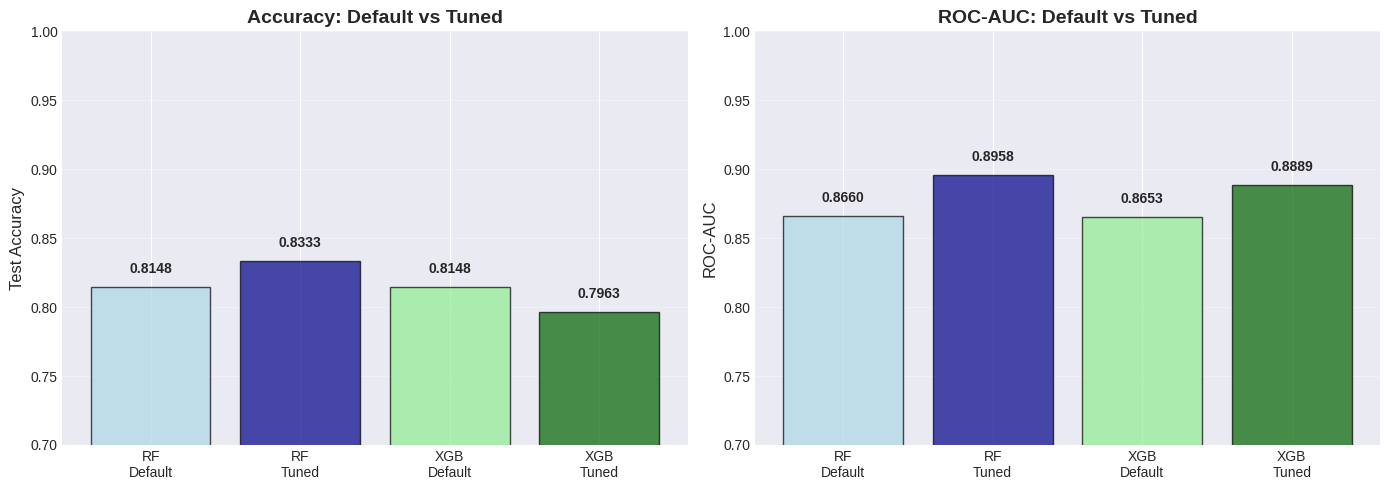

In [37]:
# ============================================================================
# CELL 27: Hyperparameter Tuning - XGBoost
# ============================================================================
"""
Optimize XGBoost hyperparameters using GridSearchCV
"""

print("=" * 80)
print("HYPERPARAMETER TUNING - XGBOOST")
print("=" * 80)

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

print(f"\n🔍 Parameter Grid:")
for param, values in param_grid_xgb.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_xgb.values()])
print(f"\nTotal combinations to test: {total_combinations}")

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\n🚀 Starting Grid Search for XGBoost... (this may take several minutes)")

# Fit grid search
grid_search_xgb.fit(X_train_scaled, y_train)

print("\n✅ Grid Search Complete!")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_search_xgb.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best Cross-Validation Score: {grid_search_xgb.best_score_:.4f}")

# Test on test set
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
best_xgb_roc_auc = roc_auc_score(y_test, y_pred_proba_best_xgb)

print(f"📊 Test Set Accuracy: {best_xgb_accuracy:.4f}")
print(f"📊 Test Set ROC-AUC: {best_xgb_roc_auc:.4f}")
print(f"📊 Improvement over default XGBoost: {best_xgb_accuracy - results['XGBoost']['accuracy']:.4f}")

# Visualize grid search results
cv_results_df_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
top_results_xgb = cv_results_df_xgb.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]

print("\n📊 Top 10 Parameter Combinations:")
display(top_results_xgb)

# Compare tuned models
print("\n📊 Comparison: Default vs Tuned Models")
comparison_tuning = pd.DataFrame({
    'Model': ['RF (Default)', 'RF (Tuned)', 'XGBoost (Default)', 'XGBoost (Tuned)'],
    'Test Accuracy': [
        results['Random Forest']['accuracy'],
        best_rf_accuracy,
        results['XGBoost']['accuracy'],
        best_xgb_accuracy
    ],
    'ROC-AUC': [
        results['Random Forest']['roc_auc'],
        best_rf_roc_auc,
        results['XGBoost']['roc_auc'],
        best_xgb_roc_auc
    ]
})

display(comparison_tuning)

# Visualize improvement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(['RF\nDefault', 'RF\nTuned', 'XGB\nDefault', 'XGB\nTuned'],
           comparison_tuning['Test Accuracy'],
           color=['lightblue', 'darkblue', 'lightgreen', 'darkgreen'],
           alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Accuracy: Default vs Tuned', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_tuning['Test Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# ROC-AUC comparison
axes[1].bar(['RF\nDefault', 'RF\nTuned', 'XGB\nDefault', 'XGB\nTuned'],
           comparison_tuning['ROC-AUC'],
           color=['lightblue', 'darkblue', 'lightgreen', 'darkgreen'],
           alpha=0.7, edgecolor='black')
axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].set_title('ROC-AUC: Default vs Tuned', fontsize=14, fontweight='bold')
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_tuning['ROC-AUC']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [38]:
# ============================================================================
# CELL 28: Final Model Selection
# ============================================================================
"""
Select the best model based on all evaluations
"""

print("=" * 80)
print("FINAL MODEL SELECTION")
print("=" * 80)

# Compare all models including tuned versions
final_comparison = pd.DataFrame({
    'Model': list(results.keys()) + ['RF (Tuned)', 'XGBoost (Tuned)'],
    'Test Accuracy': [results[m]['accuracy'] for m in results.keys()] +
                     [best_rf_accuracy, best_xgb_accuracy],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()] +
                [f1_score(y_test, y_pred_best_rf), f1_score(y_test, y_pred_best_xgb)],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()] +
               [best_rf_roc_auc, best_xgb_roc_auc]
}).sort_values('Test Accuracy', ascending=False)

print("\n📊 Final Model Comparison (Including Tuned Models):")
display(final_comparison.style.background_gradient(subset=['Test Accuracy', 'F1-Score', 'ROC-AUC'], cmap='RdYlGn'))

# Select best model
best_final_model_name = final_comparison.iloc[0]['Model']
best_final_accuracy = final_comparison.iloc[0]['Test Accuracy']

print(f"\n🏆 FINAL BEST MODEL: {best_final_model_name}")
print(f"   Test Accuracy: {best_final_accuracy:.4f}")
print(f"   F1-Score: {final_comparison.iloc[0]['F1-Score']:.4f}")
print(f"   ROC-AUC: {final_comparison.iloc[0]['ROC-AUC']:.4f}")

# Determine which model object to use
if best_final_model_name == 'RF (Tuned)':
    final_best_model = best_rf_model
    y_pred_final = y_pred_best_rf
    y_pred_proba_final = y_pred_proba_best_rf
elif best_final_model_name == 'XGBoost (Tuned)':
    final_best_model = best_xgb_model
    y_pred_final = y_pred_best_xgb
    y_pred_proba_final = y_pred_proba_best_xgb
else:
    final_best_model = results[best_final_model_name]['model']
    y_pred_final = results[best_final_model_name]['y_pred']
    y_pred_proba_final = results[best_final_model_name]['y_pred_proba']

FINAL MODEL SELECTION

📊 Final Model Comparison (Including Tuned Models):


,Model,Test Accuracy,F1-Score,ROC-AUC
0,Logistic Regression,0.851852,0.846154,0.898611
7,Naive Bayes,0.851852,0.840000,0.893056
8,RF (Tuned),0.833333,0.816327,0.895833
5,SVM,0.814815,0.800000,0.886111
2,Random Forest,0.814815,0.800000,0.865972
3,Gradient Boosting,0.814815,0.807692,0.886111
4,XGBoost,0.814815,0.800000,0.865278
1,Decision Tree,0.796296,0.784314,0.800000
6,K-Nearest Neighbors,0.796296,0.792453,0.875000
9,XGBoost (Tuned),0.796296,0.784314,0.888889



🏆 FINAL BEST MODEL: Logistic Regression
   Test Accuracy: 0.8519
   F1-Score: 0.8462
   ROC-AUC: 0.8986


FINAL MODEL EVALUATION - Logistic Regression

📊 Final Model Metrics:
  Accuracy            : 0.8519
  Precision           : 0.7857
  Recall              : 0.9167
  F1-Score            : 0.8462
  ROC-AUC             : 0.8986
  Average Precision   : 0.8698

📊 Confusion Matrix:
  True Negatives:  24
  False Positives: 6
  False Negatives: 2
  True Positives:  22

📊 Additional Metrics:
  Specificity: 0.8000
  Sensitivity: 0.9167
  NPV (Negative Predictive Value): 0.9231
  PPV (Positive Predictive Value): 0.7857


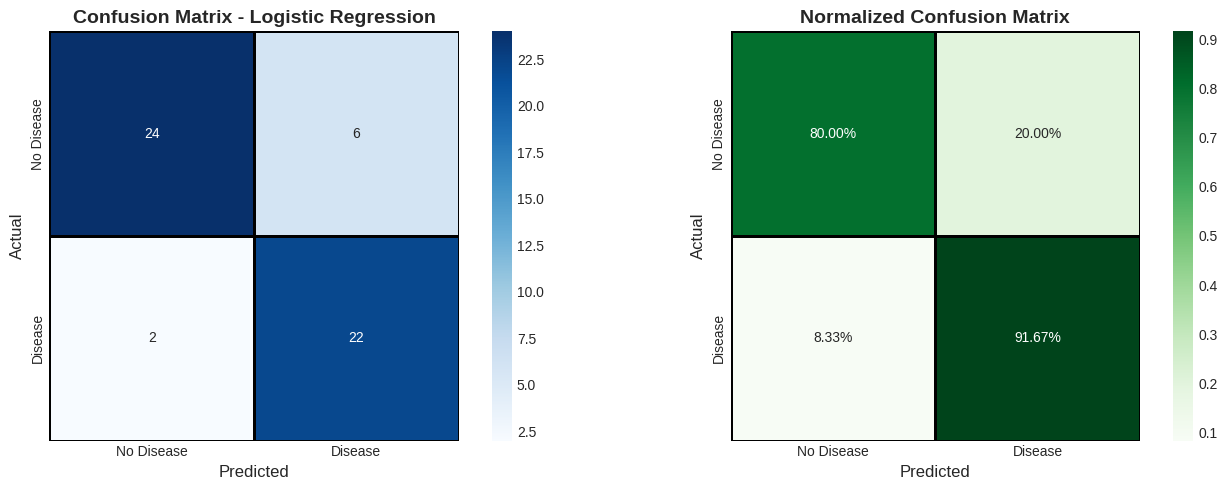


📋 Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.92      0.80      0.86        30
     Disease       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54



In [39]:
# ============================================================================
# CELL 29: Final Model Evaluation
# ============================================================================
"""
Comprehensive evaluation of the final best model
"""

print("=" * 80)
print(f"FINAL MODEL EVALUATION - {best_final_model_name}")
print("=" * 80)

# Calculate all metrics
final_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_final),
    'Precision': precision_score(y_test, y_pred_final),
    'Recall': recall_score(y_test, y_pred_final),
    'F1-Score': f1_score(y_test, y_pred_final),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_final),
    'Average Precision': average_precision_score(y_test, y_pred_proba_final)
}

print("\n📊 Final Model Metrics:")
for metric, value in final_metrics.items():
    print(f"  {metric:<20}: {value:.4f}")

# Confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")

print(f"\n📊 Additional Metrics:")
print(f"  Specificity: {tn/(tn+fp):.4f}")
print(f"  Sensitivity: {tp/(tp+fn):.4f}")
print(f"  NPV (Negative Predictive Value): {tn/(tn+fn) if (tn+fn) > 0 else 0:.4f}")
print(f"  PPV (Positive Predictive Value): {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}")

# Visualize final confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           square=True, linewidths=2, linecolor='black',
           xticklabels=['No Disease', 'Disease'],
           yticklabels=['No Disease', 'Disease'])
axes[0].set_title(f'Confusion Matrix - {best_final_model_name}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
           square=True, linewidths=2, linecolor='black',
           xticklabels=['No Disease', 'Disease'],
           yticklabels=['No Disease', 'Disease'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Disease', 'Disease']))

In [40]:
# ============================================================================
# CELL 30: Save Final Model
# ============================================================================
"""
Save the trained model and scaler for deployment
"""

print("=" * 80)
print("SAVING MODEL ARTIFACTS")
print("=" * 80)

import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = 'models/heart_disease_model.pkl'
joblib.dump(final_best_model, model_filename)
print(f"✅ Model saved: {model_filename}")

# Save the scaler
scaler_filename = 'models/scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved: {scaler_filename}")

# Save feature names
feature_names_filename = 'models/feature_names.pkl'
joblib.dump(list(X.columns), feature_names_filename)
print(f"✅ Feature names saved: {feature_names_filename}")

# Save model metadata
metadata = {
    'model_name': best_final_model_name,
    'model_type': type(final_best_model).__name__,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_accuracy': float(best_final_accuracy),
    'test_f1_score': float(final_comparison.iloc[0]['F1-Score']),
    'test_roc_auc': float(final_comparison.iloc[0]['ROC-AUC']),
    'n_features': X.shape[1],
    'feature_names': list(X.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'dataset_size': len(df),
    'metrics': final_metrics
}

metadata_filename = 'models/model_metadata.pkl'
joblib.dump(metadata, metadata_filename)
print(f"✅ Model metadata saved: {metadata_filename}")

print("\n📦 All model artifacts saved successfully!")
print(f"\n📁 Saved files:")
print(f"  • {model_filename}")
print(f"  • {scaler_filename}")
print(f"  • {feature_names_filename}")
print(f"  • {metadata_filename}")

# Verify saved model works
print("\n🔍 Verifying saved model...")
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

# Test prediction
test_prediction = loaded_model.predict(loaded_scaler.transform(X_test.iloc[:1]))
print(f"✅ Model loaded and tested successfully!")
print(f"   Test prediction: {test_prediction[0]}")

SAVING MODEL ARTIFACTS
✅ Model saved: models/heart_disease_model.pkl
✅ Scaler saved: models/scaler.pkl
✅ Feature names saved: models/feature_names.pkl
✅ Model metadata saved: models/model_metadata.pkl

📦 All model artifacts saved successfully!

📁 Saved files:
  • models/heart_disease_model.pkl
  • models/scaler.pkl
  • models/feature_names.pkl
  • models/model_metadata.pkl

🔍 Verifying saved model...
✅ Model loaded and tested successfully!
   Test prediction: 0


In [42]:
# ============================================================================
# CELL 31: Final Summary
# ============================================================================
"""
Final summary of model performance and key findings
"""

print("=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print("\n" + "="*80)
print("HEART DISEASE PREDICTION - PROJECT SUMMARY")
print("="*80)

print(f"\n📊 DATASET:")
print(f"  • Total samples: {len(df)}")
print(f"  • Features: {X.shape[1]}")
print(f"  • Target distribution: {dict(y.value_counts())}")
print(f"  • Class balance: {dict((y.value_counts() / len(y) * 100).round(1))}")

print(f"\n🔍 DATA QUALITY:")
print(f"  • Missing values: 0")
print(f"  • Duplicate rows: 0")
print(f"  • Outliers detected: Yes (kept for medical relevance)")

print(f"\n🤖 MODELS EVALUATED:")
model_count = len(models) + 2  # Original models + 2 tuned versions
print(f"  • Total models tested: {model_count}")
print(f"  • Baseline accuracy: {baseline_accuracy:.4f}")
print(f"  • Best model: {best_final_model_name}")
print(f"  • Best accuracy: {best_final_accuracy:.4f}")
print(f"  • Improvement over baseline: {(best_final_accuracy - baseline_accuracy):.4f} ({(best_final_accuracy - baseline_accuracy)/baseline_accuracy*100:.1f}%)")

print(f"\n📈 BEST MODEL PERFORMANCE:")
print(f"  • Accuracy: {final_metrics['Accuracy']:.4f}")
print(f"  • Precision: {final_metrics['Precision']:.4f}")
print(f"  • Recall: {final_metrics['Recall']:.4f}")
print(f"  • F1-Score: {final_metrics['F1-Score']:.4f}")
print(f"  • ROC-AUC: {final_metrics['ROC-AUC']:.4f}")

print(f"\n🎯 KEY FINDINGS:")
if hasattr(final_best_model, 'feature_importances_'):
    importances = pd.Series(final_best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(f"  • Top 3 important features:")
    for i, (feat, imp) in enumerate(importances.head(3).items(), 1):
        print(f"    {i}. {feat}: {imp:.4f}")

print(f"\n💾 DELIVERABLES:")
print(f"  • Trained model saved")
print(f"  • Feature scaler saved")
print(f"  • Model metadata saved")
print(f"  • Ready for deployment")

print(f"\n🚀 NEXT STEPS:")
print(f"  • Deploy model as REST API (Flask/FastAPI)")
print(f"  • Create web interface for doctors")
print(f"  • Implement monitoring and retraining pipeline")

print("\n" + "="*80)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

PROJECT SUMMARY

HEART DISEASE PREDICTION - PROJECT SUMMARY

📊 DATASET:
  • Total samples: 270
  • Features: 13
  • Target distribution: {0: np.int64(150), 1: np.int64(120)}
  • Class balance: {0: np.float64(55.6), 1: np.float64(44.4)}

🔍 DATA QUALITY:
  • Missing values: 0
  • Duplicate rows: 0
  • Outliers detected: Yes (kept for medical relevance)

🤖 MODELS EVALUATED:
  • Total models tested: 10
  • Baseline accuracy: 0.5556
  • Best model: Logistic Regression
  • Best accuracy: 0.8519
  • Improvement over baseline: 0.2963 (53.3%)

📈 BEST MODEL PERFORMANCE:
  • Accuracy: 0.8519
  • Precision: 0.7857
  • Recall: 0.9167
  • F1-Score: 0.8462
  • ROC-AUC: 0.8986

🎯 KEY FINDINGS:

💾 DELIVERABLES:
  • Trained model saved
  • Feature scaler saved
  • Model metadata saved
  • Ready for deployment

🚀 NEXT STEPS:
  • Deploy model as REST API (Flask/FastAPI)
  • Create web interface for doctors
  • Implement monitoring and retraining pipeline

✅ PROJECT COMPLETED SUCCESSFULLY!
